<a href="https://colab.research.google.com/github/Dakudai123/CSCI218_FT16_AdultDataset/blob/main/CSCI218_FT16_AdultDataSet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CSCI218 Group FT16
# Topic: AdultDataSet

Group Members:

HooJiaSheng (8761656)

Kim Minkee (8865528)

Chuan Yuhong Addison (1035800)

Russell Lim (8335564)

Kaung Khant Kyaw (8551595)

Xavier Lee (8676592)

In [ ]:
!pip install -q xgboost lightgbm

print("Packages installed successfully!")

Packages installed successfully!


Import libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, confusion_matrix, classification_report,
                             roc_auc_score, roc_curve)


from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)


Loading the Dataset from the UCL Machine Learning Repository

In [ ]:
print("LOADING ADULT INCOME DATASET")

column_names = ['age', 'workclass', 'fnlwgt', 'education', 'education-num',
                'marital-status', 'occupation', 'relationship', 'race', 'sex',
                'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income']


url_train = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
url_test = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test"


print("\nDownloading dataset from UCI repository...")
df_train = pd.read_csv(url_train, names=column_names, sep=',\s*', engine='python', na_values='?')
df_test = pd.read_csv(url_test, names=column_names, sep=',\s*', engine='python',
                      na_values='?', skiprows=1)


df = pd.concat([df_train, df_test], ignore_index=True)

print(f"\nDataset loaded successfully")
print(f"  Total samples: {len(df):,}")
print(f"  Features: {len(df.columns) - 1}")
print(f"  Target: income (<=50K or >50K)")
print(f"  Shape: {df.shape}")

LOADING ADULT INCOME DATASET


Dataset loaded successfully
  Total samples: 48,842
  Features: 14
  Target: income (<=50K or >50K)
  Shape: (48842, 15)


Data Exploration

In [ ]:

print("EXPLORATORY DATA ANALYSIS")
print("-"*80)


print("\nFirst 5 rows of the dataset:")
print(df.head())


print("\nDataset Info:")
print(f"  Shape: {df.shape}")
print(f"  Columns: {df.columns.tolist()}")


print("\nMissing values:")
missing = df.isnull().sum()
if missing.sum() > 0:
    print(missing[missing > 0])
else:
    print("No missing values found")


print("\nTarget variable distribution:")
print(df['income'].value_counts())
print("\nPercentage:")
print(df['income'].value_counts(normalize=True) * 100)


categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
categorical_cols.remove('income')
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

print(f"\nCategorical features ({len(categorical_cols)}):")
for i, col in enumerate(categorical_cols, 1):
    print(f"  {i}. {col}")

print(f"\nNumerical features ({len(numerical_cols)}):")
for i, col in enumerate(numerical_cols, 1):
    print(f"  {i}. {col}")


print("\nStatistical Summary of Numerical Features:")
print(df[numerical_cols].describe())

EXPLORATORY DATA ANALYSIS
--------------------------------------------------------------------------------

First 5 rows of the dataset:
   age         workclass  fnlwgt  education  education-num  \
0   39         State-gov   77516  Bachelors             13   
1   50  Self-emp-not-inc   83311  Bachelors             13   
2   38           Private  215646    HS-grad              9   
3   53           Private  234721       11th              7   
4   28           Private  338409  Bachelors             13   

       marital-status         occupation   relationship   race     sex  \
0       Never-married       Adm-clerical  Not-in-family  White    Male   
1  Married-civ-spouse    Exec-managerial        Husband  White    Male   
2            Divorced  Handlers-cleaners  Not-in-family  White    Male   
3  Married-civ-spouse  Handlers-cleaners        Husband  Black    Male   
4  Married-civ-spouse     Prof-specialty           Wife  Black  Female   

   capital-gain  capital-loss  hours-per-week


During exploratory data analysis, inconsistencies in the income labels  trailing punctuation were identified and cleaned to ensure correct class distribution and model training. Eg. (<=50k and <=50k.)

INCOME ANALYSIS

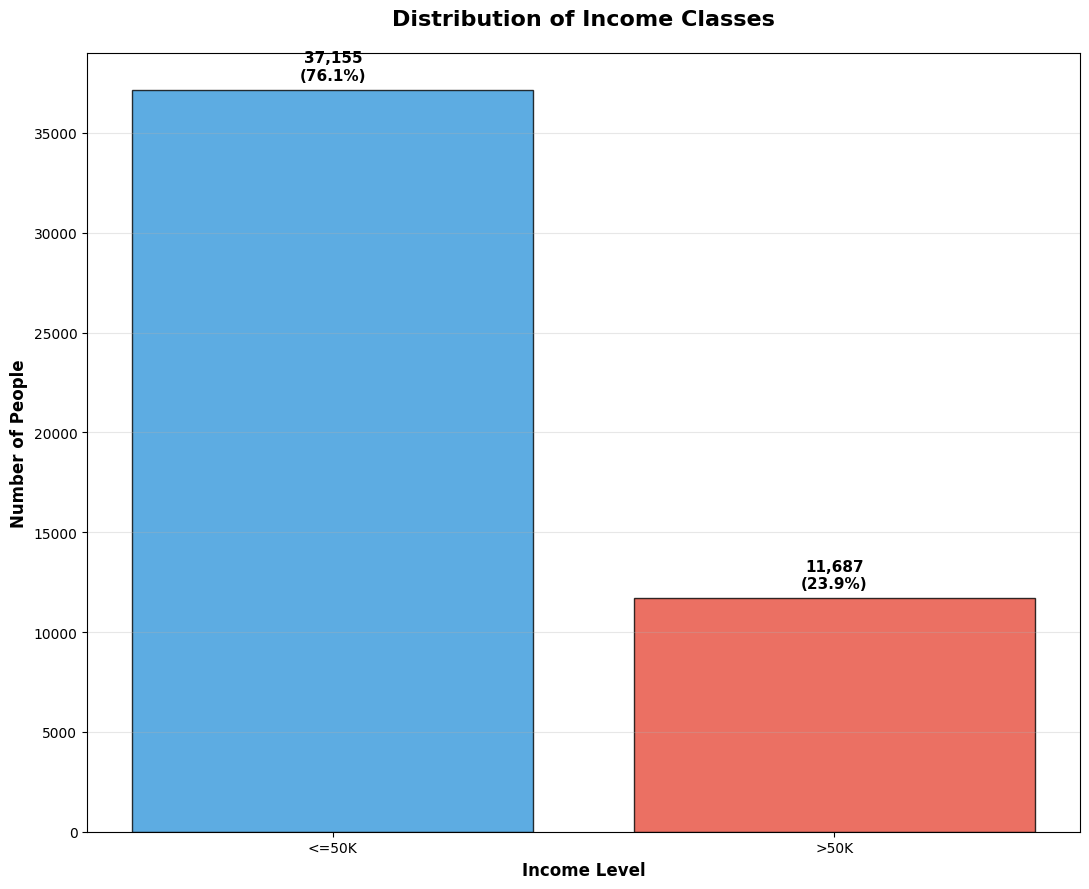


Income breakdown:
  <=50K : 37,155 (76.1%)
  >50K : 11,687 (23.9%)


In [ ]:

df_viz = df.copy()
df_viz['income'] = df_viz['income'].str.replace('.', '', regex=False).str.strip()

plt.figure(figsize=(11, 9))
income_counts = df_viz['income'].value_counts()
colors = ['#3498db', '#e74c3c']

plt.bar(income_counts.index, income_counts.values, color=colors, alpha=0.8, edgecolor='black')
plt.title('Distribution of Income Classes', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Income Level', fontsize=12, fontweight='bold')
plt.ylabel('Number of People', fontsize=12, fontweight='bold')

for i, (idx, val) in enumerate(income_counts.items()):
    plt.text(i, val + 500, f'{val:,}\n({val/len(df_viz)*100:.1f}%)',
             ha='center', fontsize=11, fontweight='bold')

plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('income_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nIncome breakdown:")
for income, count in income_counts.items():
    print(f"  {income} : {count:,} ({count/len(df_viz)*100:.1f}%)")

AGE ANALYSIS

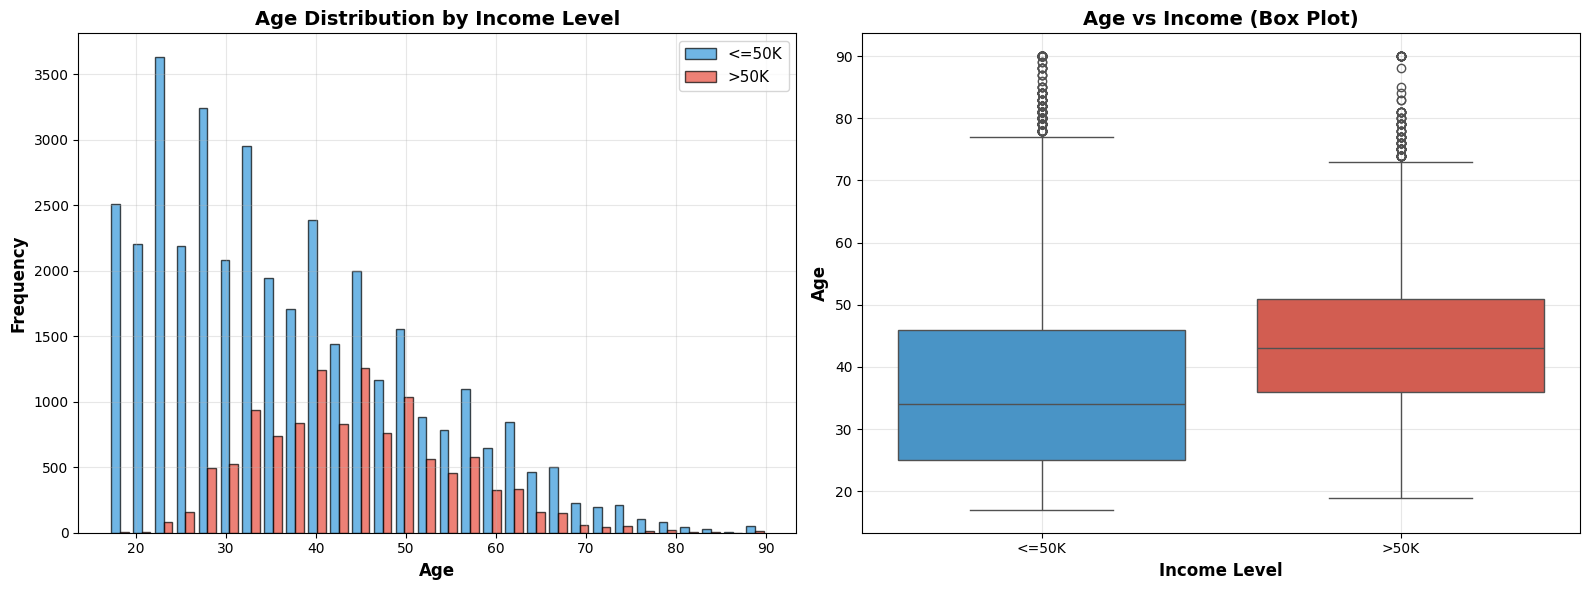


Age Statistics:
<=50K : Mean: 36.9, Median: 34.0
>50K  : Mean: 44.3, Median: 43.0

Insight: People with higher income tend to be older on average


In [ ]:

df_viz = df.copy()
df_viz['income'] = df_viz['income'].str.replace('.', '', regex=False).str.strip()

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

low_income = df_viz[df_viz['income'] == '<=50K']['age']
high_income = df_viz[df_viz['income'] == '>50K']['age']

axes[0].hist([low_income, high_income],
             bins=30, label=['<=50K', '>50K'], color=['#3498db', '#e74c3c'],
             alpha=0.7, edgecolor='black')
axes[0].set_xlabel('Age', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Frequency', fontsize=12, fontweight='bold')
axes[0].set_title('Age Distribution by Income Level', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(alpha=0.3)

sns.boxplot(x='income', y='age', data=df_viz, palette=['#3498db', '#e74c3c'], ax=axes[1])
axes[1].set_xlabel('Income Level', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Age', fontsize=12, fontweight='bold')
axes[1].set_title('Age vs Income (Box Plot)', fontsize=14, fontweight='bold')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('age_analysis.png', dpi=300, bbox_inches='tight')
plt.show()


print(f"\nAge Statistics:")
print(f"<=50K : Mean: {low_income.mean():.1f}, Median: {low_income.median():.1f}")
print(f">50K  : Mean: {high_income.mean():.1f}, Median: {high_income.median():.1f}")
print("\nInsight: People with higher income tend to be older on average")


<Figure size 1400x700 with 0 Axes>

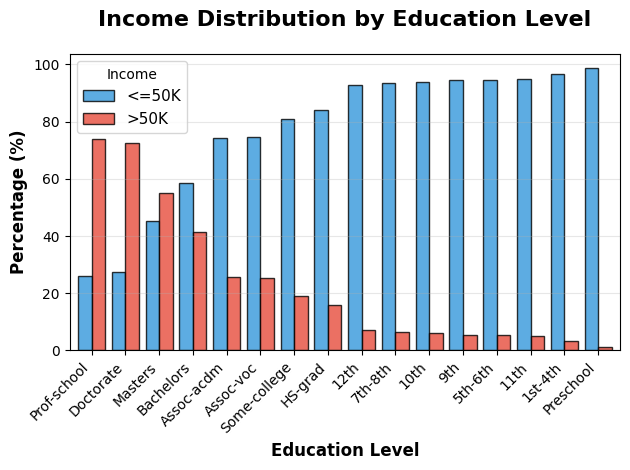


Education levels with highest % of >50K earners:
  Prof-school: 74.0%
  Doctorate: 72.6%
  Masters: 54.9%
  Bachelors: 41.3%
  Assoc-acdm: 25.8%

Insight: Higher education levels correlate with higher income


In [ ]:

df_viz = df.copy()
df_viz['income'] = df_viz['income'].str.replace('.', '', regex=False).str.strip()

plt.figure(figsize=(14, 7))

education_income = pd.crosstab(df_viz['education'], df_viz['income'], normalize='index') * 100
education_income = education_income.sort_values(by='>50K', ascending=False)

education_income.plot(kind='bar', color=['#3498db', '#e74c3c'], alpha=0.8,
                     edgecolor='black', width=0.8)

plt.title('Income Distribution by Education Level', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Education Level', fontsize=12, fontweight='bold')
plt.ylabel('Percentage (%)', fontsize=12, fontweight='bold')
plt.legend(title='Income', labels=['<=50K', '>50K'], fontsize=11)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('education_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nEducation levels with highest % of >50K earners:")
top_education = education_income['>50K'].sort_values(ascending=False).head(5)
for edu, pct in top_education.items():
    print(f"  {edu}: {pct:.1f}%")

print("\nInsight: Higher education levels correlate with higher income")

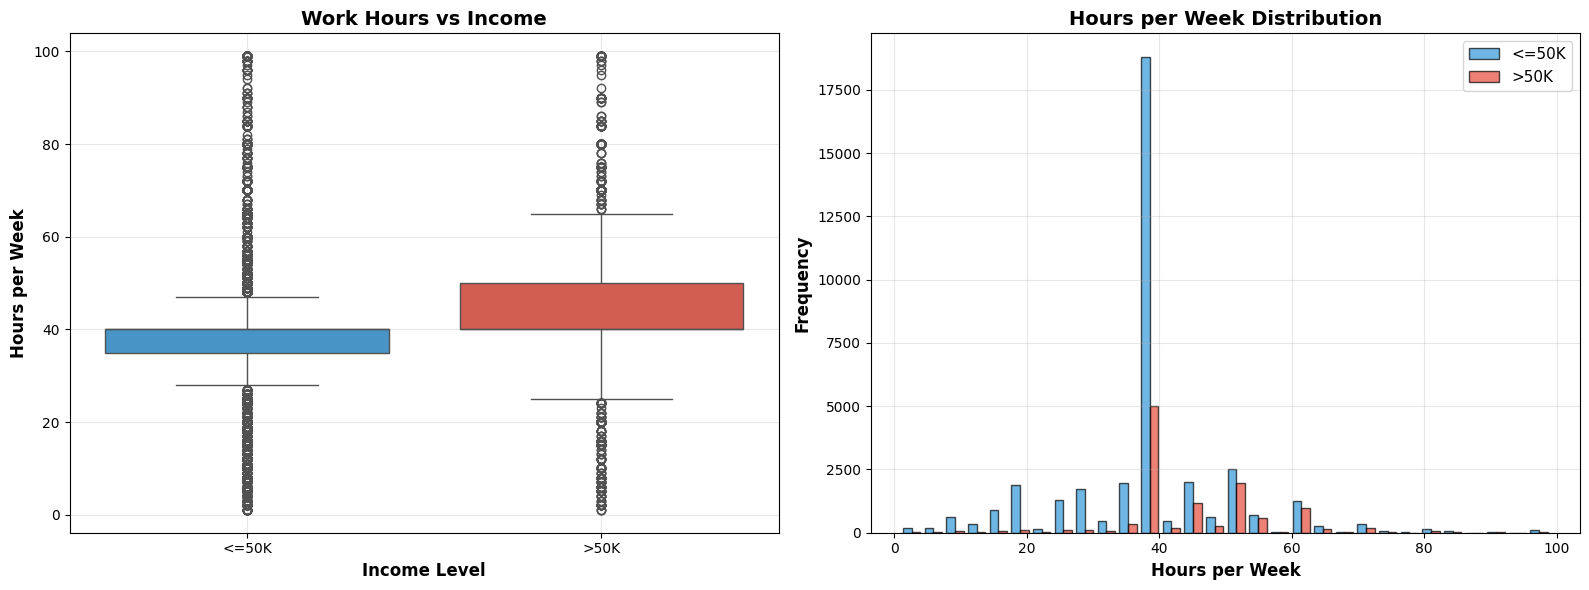


Work Hours Statistics:
<=50K : Mean: 38.8 hours, Median: 40.0 hours
>50K  : Mean: 45.5 hours, Median: 40.0 hours

Insight: Higher earners tend to work more hours per week


In [ ]:
df_viz = df.copy()
df_viz['income'] = df_viz['income'].str.replace('.', '', regex=False).str.strip()

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.boxplot(x='income', y='hours-per-week', data=df_viz,
            palette=['#3498db', '#e74c3c'], ax=axes[0])
axes[0].set_xlabel('Income Level', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Hours per Week', fontsize=12, fontweight='bold')
axes[0].set_title('Work Hours vs Income', fontsize=14, fontweight='bold')
axes[0].grid(alpha=0.3)

low_income_hours = df_viz[df_viz['income'] == '<=50K']['hours-per-week']
high_income_hours = df_viz[df_viz['income'] == '>50K']['hours-per-week']

axes[1].hist([low_income_hours, high_income_hours],
             bins=30, label=['<=50K', '>50K'], color=['#3498db', '#e74c3c'],
             alpha=0.7, edgecolor='black')
axes[1].set_xlabel('Hours per Week', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Frequency', fontsize=12, fontweight='bold')
axes[1].set_title('Hours per Week Distribution', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('hours_analysis.png', dpi=300, bbox_inches='tight')
plt.show()


# Print statistics
print(f"\nWork Hours Statistics:")
print(f"<=50K : Mean: {low_income_hours.mean():.1f} hours, Median: {low_income_hours.median():.1f} hours")
print(f">50K  : Mean: {high_income_hours.mean():.1f} hours, Median: {high_income_hours.median():.1f} hours")
print("\nInsight: Higher earners tend to work more hours per week")

CORRELATION HEATMAP OF THE NUMERICAL FEATURES

CORRELATION HEATMAP


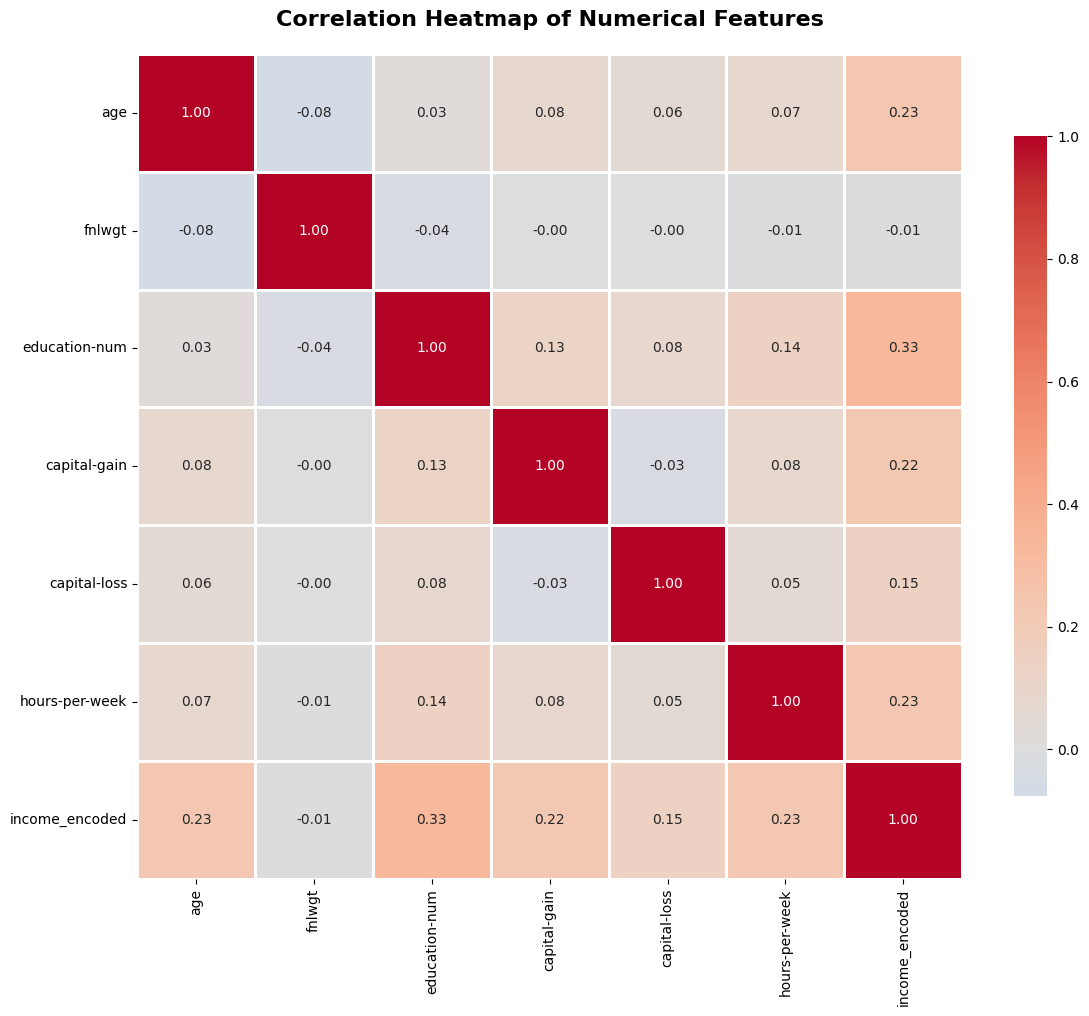


Key correlations with income:
education-num     0.332613
age               0.230369
hours-per-week    0.227687
capital-gain      0.223013
capital-loss      0.147554
Name: income_encoded, dtype: float64

Strongest positive correlations with high income:
  education-num: 0.333
  age: 0.230
  hours-per-week: 0.228


In [ ]:
print("CORRELATION HEATMAP")


plt.figure(figsize=(12, 10))

df_viz = df.copy()
df_viz['income'] = df_viz['income'].str.replace('.', '', regex=False).str.strip()

numerical_df = df_viz[numerical_cols].copy()

numerical_df['income_encoded'] = (df_viz['income'] == '>50K').astype(int)


correlation = numerical_df.corr()


sns.heatmap(correlation, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Correlation Heatmap of Numerical Features', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('correlation_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()


print("\nKey correlations with income:")
income_corr = correlation['income_encoded'].sort_values(ascending=False)
income_corr = income_corr[income_corr.index != 'income_encoded']
print(income_corr.head(5))

print(f"\nStrongest positive correlations with high income:")
for feature, corr_val in income_corr.head(3).items():
    print(f"  {feature}: {corr_val:.3f}")


GENDER AND OCCUPATION

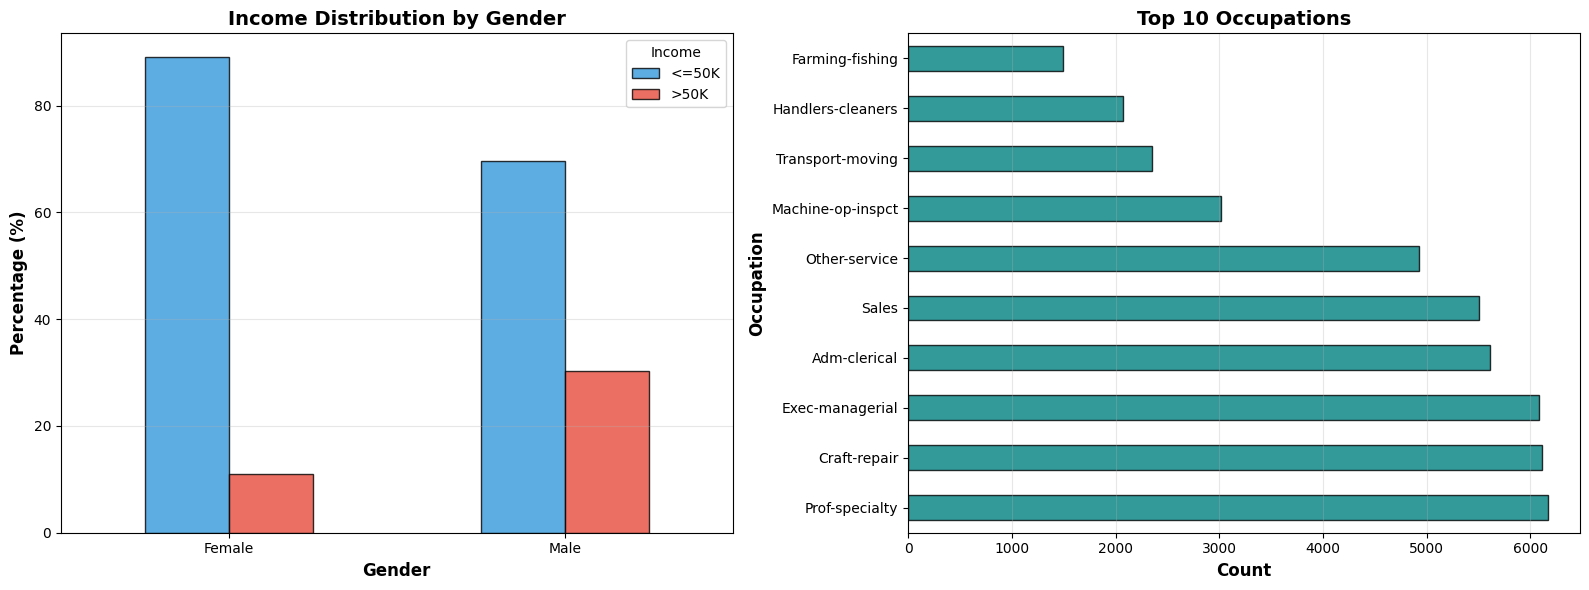


Gender and Income Breakdown:
  Female: 10.9% earn >50K
  Male: 30.4% earn >50K

Most Common Occupations:
  1. Prof-specialty: 6,172 people
  2. Craft-repair: 6,112 people
  3. Exec-managerial: 6,086 people
  4. Adm-clerical: 5,611 people
  5. Sales: 5,504 people


In [ ]:

df_viz = df.copy()
df_viz['income'] = df_viz['income'].str.replace('.', '', regex=False).str.strip()

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

gender_income = pd.crosstab(df_viz['sex'], df_viz['income'], normalize='index') * 100
gender_income.plot(kind='bar', color=['#3498db', '#e74c3c'], ax=axes[0],
                  alpha=0.8, edgecolor='black')
axes[0].set_title('Income Distribution by Gender', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Gender', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Percentage (%)', fontsize=12, fontweight='bold')
axes[0].legend(title='Income', labels=['<=50K', '>50K'])
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=0)
axes[0].grid(axis='y', alpha=0.3)

occupation_counts = df_viz['occupation'].value_counts().head(10)
occupation_counts.plot(kind='barh', color='teal', ax=axes[1], alpha=0.8, edgecolor='black')
axes[1].set_title('Top 10 Occupations', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Count', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Occupation', fontsize=12, fontweight='bold')
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('gender_occupation_analysis.png', dpi=300, bbox_inches='tight')
plt.show()


print(f"\nGender and Income Breakdown:")
for gender in gender_income.index:
    high_income_pct = gender_income.loc[gender, '>50K']
    print(f"  {gender}: {high_income_pct:.1f}% earn >50K")

print(f"\nMost Common Occupations:")
for i, (occupation, count) in enumerate(occupation_counts.head(5).items(), 1):
    print(f"  {i}. {occupation}: {count:,} people")


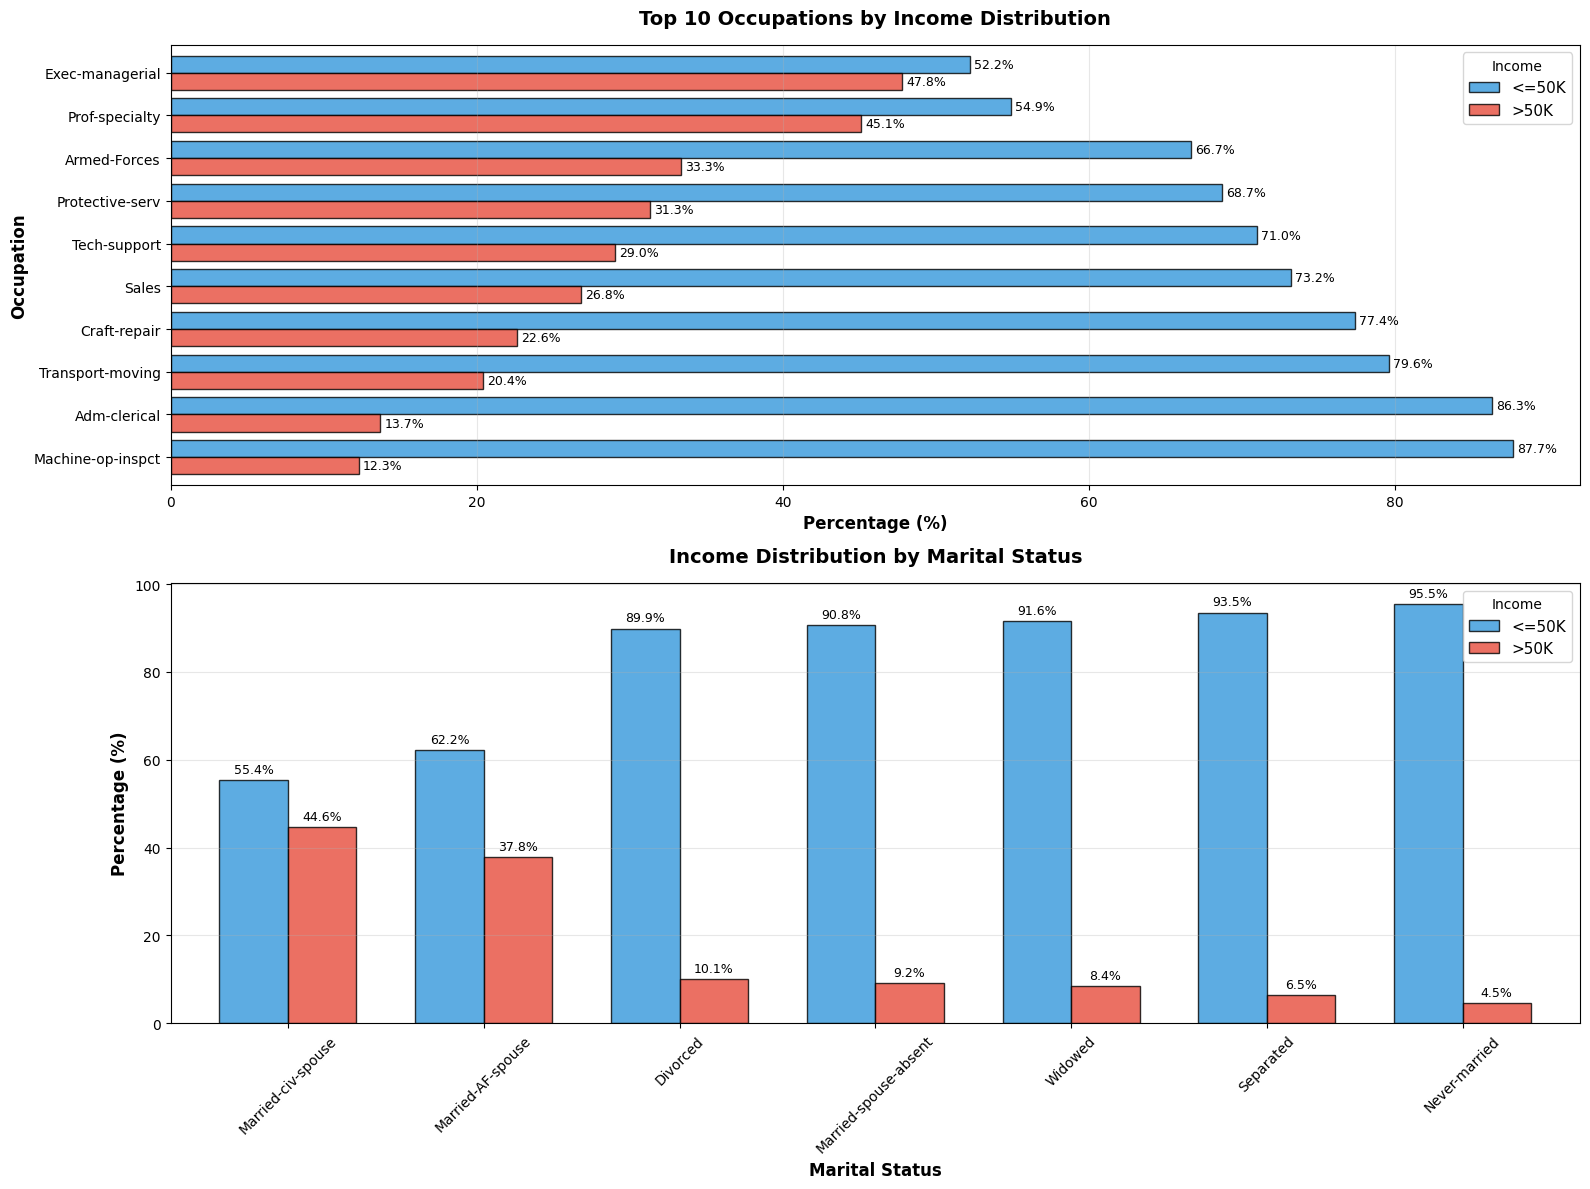


KEY INSIGHTS:

Top 10 Occupations with Highest >50K Percentage:
  1. Exec-managerial: 47.8% earn >50K
  2. Prof-specialty: 45.1% earn >50K
  3. Armed-Forces: 33.3% earn >50K
  4. Protective-serv: 31.3% earn >50K
  5. Tech-support: 29.0% earn >50K
  6. Sales: 26.8% earn >50K
  7. Craft-repair: 22.6% earn >50K
  8. Transport-moving: 20.4% earn >50K
  9. Adm-clerical: 13.7% earn >50K
  10. Machine-op-inspct: 12.3% earn >50K

Marital Status with Highest >50K Percentage:
  1. Married-civ-spouse: 44.6% earn >50K
  2. Married-AF-spouse: 37.8% earn >50K
  3. Divorced: 10.1% earn >50K
  4. Married-spouse-absent: 9.2% earn >50K
  5. Widowed: 8.4% earn >50K
  6. Separated: 6.5% earn >50K
  7. Never-married: 4.5% earn >50K


In [ ]:
df_viz = df.copy()
df_viz['income'] = df_viz['income'].str.replace('.', '', regex=False).str.strip()

fig, axes = plt.subplots(2, 1, figsize=(16, 12))

occupation_income = pd.crosstab(df_viz['occupation'], df_viz['income'], normalize='index') * 100

occupation_income = occupation_income.sort_values(by='>50K', ascending=False).head(10)

occupation_income.plot(kind='barh', ax=axes[0], color=['#3498db', '#e74c3c'],
                      alpha=0.8, edgecolor='black', width=0.8)

axes[0].set_title('Top 10 Occupations by Income Distribution',
                  fontsize=14, fontweight='bold', pad=15)
axes[0].set_xlabel('Percentage (%)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Occupation', fontsize=12, fontweight='bold')
axes[0].legend(title='Income', labels=['<=50K', '>50K'], fontsize=11)
axes[0].grid(axis='x', alpha=0.3)
axes[0].invert_yaxis()

for container in axes[0].containers:
    axes[0].bar_label(container, fmt='%.1f%%', padding=3, fontsize=9)



marital_income = pd.crosstab(df_viz['marital-status'], df_viz['income'], normalize='index') * 100

marital_income = marital_income.sort_values(by='>50K', ascending=False)

marital_income.plot(kind='bar', ax=axes[1], color=['#3498db', '#e74c3c'],
                   alpha=0.8, edgecolor='black', width=0.7)

axes[1].set_title('Income Distribution by Marital Status',
                  fontsize=14, fontweight='bold', pad=15)
axes[1].set_xlabel('Marital Status', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Percentage (%)', fontsize=12, fontweight='bold')
axes[1].legend(title='Income', labels=['<=50K', '>50K'], fontsize=11)
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(axis='y', alpha=0.3)

for container in axes[1].containers:
    axes[1].bar_label(container, fmt='%.1f%%', padding=3, fontsize=9)

plt.tight_layout()
plt.savefig('income_by_occupation_marital.png', dpi=300, bbox_inches='tight')
plt.show()


print("\nKEY INSIGHTS:")
print("\nTop 10 Occupations with Highest >50K Percentage:")
for i, (occupation, row) in enumerate(occupation_income.iterrows(), 1):
    print(f"  {i}. {occupation}: {row['>50K']:.1f}% earn >50K")

print("\nMarital Status with Highest >50K Percentage:")
for i, (status, row) in enumerate(marital_income.iterrows(), 1):
    print(f"  {i}. {status}: {row['>50K']:.1f}% earn >50K")

DATA PREPROCESSING : HANDLE MISSING VALUES

In [ ]:

df_processed = df.copy()

df_processed['income'] = df_processed['income'].str.replace('.', '', regex=False).str.strip()

print("\nMISSING VALUES ANALYSIS:")
print("-"*80)

missing_before = df_processed.isnull().sum()
missing_cols = missing_before[missing_before > 0]

if len(missing_cols) > 0:
    print("\nColumns with missing values:")
    for col, count in missing_cols.items():
        pct = (count / len(df_processed)) * 100
        print(f"  • {col}: {count:,} missing ({pct:.2f}%)")

    total_missing = missing_cols.sum()
    print(f"\nTotal missing values: {total_missing:,}")
    print(f"  Rows with any missing: {df_processed.isnull().any(axis=1).sum():,}")
    print(f"  Percentage of data: {df_processed.isnull().any(axis=1).sum()/len(df_processed)*100:.2f}%")
else:
    print("\nNo missing values found!")


print("\nMISSINGNESS PATTERN ANALYSIS:")
print("-"*80)

if len(missing_cols) > 0:
    print("\nDo missing values correlate with income?")
    for col in missing_cols.index:
        has_missing = df_processed[col].isnull()


        income_when_missing = df_processed[has_missing]['income'].value_counts(normalize=True)

        income_when_present = df_processed[~has_missing]['income'].value_counts(normalize=True)

        print(f"\n  {col}:")
        print(f"    When {col} is MISSING:")
        for income_val, pct in income_when_missing.items():
            print(f"      {income_val}: {pct*100:.1f}%")
        print(f"    When {col} is PRESENT:")
        for income_val, pct in income_when_present.items():
            print(f"      {income_val}: {pct*100:.1f}%")


print("\nMISSING VALUE HANDLING STRATEGY DECISION:")
print("-"*80)


if len(missing_cols) > 0:
    pct_rows_with_missing = (df_processed.isnull().any(axis=1).sum() / len(df_processed)) * 100

    print(f"\nTotal rows with any missing value: {pct_rows_with_missing:.2f}%")

    if pct_rows_with_missing > 10:
        print("\nHigh percentage of missing data (>10%)")
        print("    Recommendation: Use imputation (dropping would lose too much data)")
        strategy = "impute"
    elif pct_rows_with_missing < 1:
        print("\nLow percentage of missing data (<1%)")
        print("    Recommendation: Could safely drop rows")
        strategy = "drop"
    else:
        print("\nModerate percentage of missing data (1-10%)")
        print("    Recommendation: Imputation preferred, but dropping is acceptable")
        strategy = "impute"

    if strategy == "impute":
        print("\nSELECTED STRATEGY: IMPUTATION")
        print("IMPUTATION METHOD: Creating 'Unknown' category for missing values")
    elif strategy == "drop":
        print("\nSELECTED STRATEGY: DROPPING ROWS WITH MISSING VALUES")
    else:
        print("\nSELECTED STRATEGY: NONE REQUIRED")


print("\nAPPLYING IMPUTATION:")
print("-"*80)

if strategy == "impute":

    print("\nUsing UNKNOWN CATEGORY CREATION for missing values:")
    print("  Rationale: Treats missing values as a separate category")
    print("  Advantage: Preserves missingness information without biasing distribution")
    print("  Assumption: Missing values may carry meaningful information\n")

    for col in categorical_cols:
        if df_processed[col].isnull().sum() > 0:
            df_processed[col].fillna('Unknown', inplace=True)
            print(f"Filled '{col}' with: Unknown")


elif strategy == "drop":

    rows_before = len(df_processed)
    df_processed = df_processed.dropna()
    rows_after = len(df_processed)
    rows_dropped = rows_before - rows_after

    print(f"\nDropped {rows_dropped:,} rows with missing values")
    print(f"Remaining: {rows_after:,} rows ({rows_after/rows_before*100:.2f}%)")

else:
    print("\nNo missing values to handle")



print("\nVERIFICATION:")
print("-"*80)

missing_after = df_processed.isnull().sum()
total_missing_after = missing_after.sum()

if total_missing_after == 0:
    print("\nAll missing values have been handled")
    print(f"  Final dataset: {df_processed.shape[0]:,} rows × {df_processed.shape[1]} columns")
else:
    print(f"\nStill have {total_missing_after:,} missing values:")
    print(missing_after[missing_after > 0])



print("\nIMPACT OF IMPUTATION:")
print("-"*80)

if len(missing_cols) > 0 and strategy == "impute":
    print("\nDistribution changes:")
    for col in missing_cols.index:
        if col in categorical_cols:
            print(f"\n  {col}:")

            value_counts = df_processed[col].value_counts()


            if 'Unknown' in value_counts.index:
                unknown_count = value_counts['Unknown']
                unknown_pct = (unknown_count / len(df_processed)) * 100
                print(f"    Unknown: {unknown_count:,} ({unknown_pct:.2f}%)")


            for val, count in value_counts.drop('Unknown', errors='ignore').head(3).items():
                pct = (count / len(df_processed)) * 100
                print(f"    {val}: {count:,} ({pct:.2f}%)")



MISSING VALUES ANALYSIS:
--------------------------------------------------------------------------------

Columns with missing values:
  • workclass: 2,799 missing (5.73%)
  • occupation: 2,809 missing (5.75%)
  • native-country: 857 missing (1.75%)

Total missing values: 6,465
  Rows with any missing: 3,620
  Percentage of data: 7.41%

MISSINGNESS PATTERN ANALYSIS:
--------------------------------------------------------------------------------

Do missing values correlate with income?

  workclass:
    When workclass is MISSING:
      <=50K: 90.5%
      >50K: 9.5%
    When workclass is PRESENT:
      <=50K: 75.2%
      >50K: 24.8%

  occupation:
    When occupation is MISSING:
      <=50K: 90.6%
      >50K: 9.4%
    When occupation is PRESENT:
      <=50K: 75.2%
      >50K: 24.8%

  native-country:
    When native-country is MISSING:
      <=50K: 74.3%
      >50K: 25.7%
    When native-country is PRESENT:
      <=50K: 76.1%
      >50K: 23.9%

MISSING VALUE HANDLING STRATEGY DECISIO

DATA PREPROCESSING : ENCODE CATEGORICAL VARIABLES

In [ ]:


label_encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    df_processed[col] = le.fit_transform(df_processed[col].astype(str))
    label_encoders[col] = le

    n_unique = len(le.classes_)
    print(f"{col}: {n_unique} unique values encoded")

df_processed['income'] = (df_processed['income'] == '>50K').astype(int)

print(f"\nTarget variable encoded:")
print(f"0 = <=50K")
print(f"1 = >50K")

print("\nTarget distribution after encoding:")
print(df_processed['income'].value_counts())


workclass: 9 unique values encoded
education: 16 unique values encoded
marital-status: 7 unique values encoded
occupation: 15 unique values encoded
relationship: 6 unique values encoded
race: 5 unique values encoded
sex: 2 unique values encoded
native-country: 42 unique values encoded

Target variable encoded:
0 = <=50K
1 = >50K

Target distribution after encoding:
income
0    37155
1    11687
Name: count, dtype: int64


DATA PREPROCESSING : FEATURE SELECTION

In [ ]:
print("\nOriginal features:", df_processed.shape[1])

df_processed = df_processed.drop('fnlwgt', axis=1)

print(f"Removed 'fnlwgt' (census weight : not useful for prediction)")
print(f"\nFinal features: {df_processed.shape[1] - 1} (plus target(income))")
print(f"\nFeature list:")
for i, col in enumerate(df_processed.columns[:-1], 1):
    print(f"  {i}. {col}")

print(f"\nPreprocessing complete!")
print(f"Final dataset shape: {df_processed.shape}")


Original features: 15
Removed 'fnlwgt' (census weight : not useful for prediction)

Final features: 13 (plus target(income))

Feature list:
  1. age
  2. workclass
  3. education
  4. education-num
  5. marital-status
  6. occupation
  7. relationship
  8. race
  9. sex
  10. capital-gain
  11. capital-loss
  12. hours-per-week
  13. native-country

Preprocessing complete!
Final dataset shape: (48842, 14)


SPLIT DATA TO TRAIN AND TEST SETS

In [ ]:

X = df_processed.drop('income', axis=1)
y = df_processed['income']

print(f"\nTotal samples: {len(X):,}")
print(f"Total features: {X.shape[1]}")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nData split completed")
print(f"\nTraining set: {X_train.shape[0]:,} samples ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"Test set: {X_test.shape[0]:,} samples ({X_test.shape[0]/len(X)*100:.1f}%)")

print(f"\nClass distribution in training set:")
train_dist = y_train.value_counts()
for label, count in train_dist.items():
    income_label = "<=50K" if label == 0 else ">50K"
    print(f"  {income_label}: {count:,} ({count/len(y_train)*100:.1f}%)")

print(f"\nClass distribution in test set:")
test_dist = y_test.value_counts()
for label, count in test_dist.items():
    income_label = "<=50K" if label == 0 else ">50K"
    print(f"  {income_label}: {count:,} ({count/len(y_test)*100:.1f}%)")


Total samples: 48,842
Total features: 13

Data split completed

Training set: 39,073 samples (80.0%)
Test set: 9,769 samples (20.0%)

Class distribution in training set:
  <=50K: 29,724 (76.1%)
  >50K: 9,349 (23.9%)

Class distribution in test set:
  <=50K: 7,431 (76.1%)
  >50K: 2,338 (23.9%)


FEATURE SCALING

In [ ]:
print("FEATURE SCALING")
print("-"*80)

print("\nScaling features using StandardScaler...")
print("(This makes all features have mean=0 and std=1)")

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"\nScaled training data statistics:")
print(f"  Mean: {X_train_scaled.mean():.6f}")
print(f"  Std:  {X_train_scaled.std():.6f}")

print(f"\nNote: Some algorithms (like Random Forest) don't need scaling, but others (like SVM, Neural Networks) perform better with it.")

FEATURE SCALING
--------------------------------------------------------------------------------

Scaling features using StandardScaler...
(This makes all features have mean=0 and std=1)

Scaled training data statistics:
  Mean: 0.000000
  Std:  1.000000

Note: Some algorithms (like Random Forest) don't need scaling, but others (like SVM, Neural Networks) perform better with it.


TRAIN MODELS : LOGISTIC REGRESSION & DECISION TREE

In [ ]:
results = {}

print("1. REGRESSION")
print("-"*60)

lr_model = LogisticRegression(random_state=42, max_iter=1000)
lr_model.fit(X_train_scaled, y_train)
y_pred_lr = lr_model.predict(X_test_scaled)
y_pred_proba_lr = lr_model.predict_proba(X_test_scaled)[:, 1]

lr_acc = accuracy_score(y_test, y_pred_lr)
lr_prec = precision_score(y_test, y_pred_lr)
lr_rec = recall_score(y_test, y_pred_lr)
lr_f1 = f1_score(y_test, y_pred_lr)
lr_auc = roc_auc_score(y_test, y_pred_proba_lr)
lr_cv = cross_val_score(lr_model, X_train_scaled, y_train, cv=5, scoring='accuracy')

results['Logistic Regression'] = {
    'model': lr_model,
    'accuracy': lr_acc,
    'precision': lr_prec,
    'recall': lr_rec,
    'f1_score': lr_f1,
    'roc_auc': lr_auc,
    'cv_mean': lr_cv.mean(),
    'cv_std': lr_cv.std(),
    'y_pred': y_pred_lr,
    'y_pred_proba': y_pred_proba_lr,
    'confusion_matrix': confusion_matrix(y_test, y_pred_lr)
}

print(f"Accuracy:  {lr_acc:.4f}")
print(f"Precision: {lr_prec:.4f}")
print(f"Recall:    {lr_rec:.4f}")
print(f"F1 Score:  {lr_f1:.4f}")
print(f"ROC AUC:   {lr_auc:.4f}")
print(f"CV Score:  {lr_cv.mean():.4f} (+/- {lr_cv.std():.4f})")

print("\n2. DECISION TREE")
print("-"*60)

dt_model = DecisionTreeClassifier(random_state=42, max_depth=10)
dt_model.fit(X_train, y_train)
y_pred_dt = dt_model.predict(X_test)
y_pred_proba_dt = dt_model.predict_proba(X_test)[:, 1]

dt_acc = accuracy_score(y_test, y_pred_dt)
dt_prec = precision_score(y_test, y_pred_dt)
dt_rec = recall_score(y_test, y_pred_dt)
dt_f1 = f1_score(y_test, y_pred_dt)
dt_auc = roc_auc_score(y_test, y_pred_proba_dt)
dt_cv = cross_val_score(dt_model, X_train, y_train, cv=5, scoring='accuracy')

results['Decision Tree'] = {
    'model': dt_model,
    'accuracy': dt_acc,
    'precision': dt_prec,
    'recall': dt_rec,
    'f1_score': dt_f1,
    'roc_auc': dt_auc,
    'cv_mean': dt_cv.mean(),
    'cv_std': dt_cv.std(),
    'y_pred': y_pred_dt,
    'y_pred_proba': y_pred_proba_dt,
    'confusion_matrix': confusion_matrix(y_test, y_pred_dt)
}

print(f"Accuracy:  {dt_acc:.4f}")
print(f"Precision: {dt_prec:.4f}")
print(f"Recall:    {dt_rec:.4f}")
print(f"F1 Score:  {dt_f1:.4f}")
print(f"ROC AUC:   {dt_auc:.4f}")
print(f"CV Score:  {dt_cv.mean():.4f} (+/- {dt_cv.std():.4f})")

print("\n(2/12 models trained)")

1. REGRESSION
------------------------------------------------------------
Accuracy:  0.8233
Precision: 0.7024
Recall:    0.4542
F1 Score:  0.5517
ROC AUC:   0.8498
CV Score:  0.8253 (+/- 0.0043)

2. DECISION TREE
------------------------------------------------------------
Accuracy:  0.8579
Precision: 0.7928
Recall:    0.5500
F1 Score:  0.6495
ROC AUC:   0.9002
CV Score:  0.8548 (+/- 0.0035)

(2/12 models trained)


TRAIN MODELS (Ensemble methods) : RANDOM FOREST, GRADIENT BOOSTING & XGBOOST


In [ ]:

print("\n3. RANDOM FOREST")
print("-"*60)

rf_model = RandomForestClassifier(random_state=42, n_estimators=100, max_depth=15)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
y_pred_proba_rf = rf_model.predict_proba(X_test)[:, 1]

rf_acc = accuracy_score(y_test, y_pred_rf)
rf_prec = precision_score(y_test, y_pred_rf)
rf_rec = recall_score(y_test, y_pred_rf)
rf_f1 = f1_score(y_test, y_pred_rf)
rf_auc = roc_auc_score(y_test, y_pred_proba_rf)
rf_cv = cross_val_score(rf_model, X_train, y_train, cv=5, scoring='accuracy')

results['Random Forest'] = {
    'model': rf_model,
    'accuracy': rf_acc,
    'precision': rf_prec,
    'recall': rf_rec,
    'f1_score': rf_f1,
    'roc_auc': rf_auc,
    'cv_mean': rf_cv.mean(),
    'cv_std': rf_cv.std(),
    'y_pred': y_pred_rf,
    'y_pred_proba': y_pred_proba_rf,
    'confusion_matrix': confusion_matrix(y_test, y_pred_rf)
}

print(f"Accuracy:  {rf_acc:.4f}")
print(f"Precision: {rf_prec:.4f}")
print(f"Recall:    {rf_rec:.4f}")
print(f"F1 Score:  {rf_f1:.4f}")
print(f"ROC AUC:   {rf_auc:.4f}")
print(f"CV Score:  {rf_cv.mean():.4f} (+/- {rf_cv.std():.4f})")

print("\n4. GRADIENT BOOSTING")
print("-"*60)

gb_model = GradientBoostingClassifier(random_state=42, n_estimators=100)
gb_model.fit(X_train, y_train)
y_pred_gb = gb_model.predict(X_test)
y_pred_proba_gb = gb_model.predict_proba(X_test)[:, 1]

gb_acc = accuracy_score(y_test, y_pred_gb)
gb_prec = precision_score(y_test, y_pred_gb)
gb_rec = recall_score(y_test, y_pred_gb)
gb_f1 = f1_score(y_test, y_pred_gb)
gb_auc = roc_auc_score(y_test, y_pred_proba_gb)
gb_cv = cross_val_score(gb_model, X_train, y_train, cv=5, scoring='accuracy')

results['Gradient Boosting'] = {
    'model': gb_model,
    'accuracy': gb_acc,
    'precision': gb_prec,
    'recall': gb_rec,
    'f1_score': gb_f1,
    'roc_auc': gb_auc,
    'cv_mean': gb_cv.mean(),
    'cv_std': gb_cv.std(),
    'y_pred': y_pred_gb,
    'y_pred_proba': y_pred_proba_gb,
    'confusion_matrix': confusion_matrix(y_test, y_pred_gb)
}

print(f"Accuracy:  {gb_acc:.4f}")
print(f"Precision: {gb_prec:.4f}")
print(f"Recall:    {gb_rec:.4f}")
print(f"F1 Score:  {gb_f1:.4f}")
print(f"ROC AUC:   {gb_auc:.4f}")
print(f"CV Score:  {gb_cv.mean():.4f} (+/- {gb_cv.std():.4f})")

print("\n5. XGBOOST")
print("-"*60)

xgb_model = XGBClassifier(random_state=42, n_estimators=100, eval_metric='logloss')
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)
y_pred_proba_xgb = xgb_model.predict_proba(X_test)[:, 1]

xgb_acc = accuracy_score(y_test, y_pred_xgb)
xgb_prec = precision_score(y_test, y_pred_xgb)
xgb_rec = recall_score(y_test, y_pred_xgb)
xgb_f1 = f1_score(y_test, y_pred_xgb)
xgb_auc = roc_auc_score(y_test, y_pred_proba_xgb)
xgb_cv = cross_val_score(xgb_model, X_train, y_train, cv=5, scoring='accuracy')

results['XGBoost'] = {
    'model': xgb_model,
    'accuracy': xgb_acc,
    'precision': xgb_prec,
    'recall': xgb_rec,
    'f1_score': xgb_f1,
    'roc_auc': xgb_auc,
    'cv_mean': xgb_cv.mean(),
    'cv_std': xgb_cv.std(),
    'y_pred': y_pred_xgb,
    'y_pred_proba': y_pred_proba_xgb,
    'confusion_matrix': confusion_matrix(y_test, y_pred_xgb)
}

print(f"Accuracy:  {xgb_acc:.4f}")
print(f"Precision: {xgb_prec:.4f}")
print(f"Recall:    {xgb_rec:.4f}")
print(f"F1 Score:  {xgb_f1:.4f}")
print(f"ROC AUC:   {xgb_auc:.4f}")
print(f"CV Score:  {xgb_cv.mean():.4f} (+/- {xgb_cv.std():.4f})")

print("\n(5/12 models trained)")


3. RANDOM FOREST
------------------------------------------------------------
Accuracy:  0.8670
Precision: 0.7875
Recall:    0.6086
F1 Score:  0.6866
ROC AUC:   0.9207
CV Score:  0.8641 (+/- 0.0031)

4. GRADIENT BOOSTING
------------------------------------------------------------
Accuracy:  0.8699
Precision: 0.7969
Recall:    0.6125
F1 Score:  0.6926
ROC AUC:   0.9230
CV Score:  0.8649 (+/- 0.0037)

5. XGBOOST
------------------------------------------------------------
Accuracy:  0.8767
Precision: 0.7863
Recall:    0.6655
F1 Score:  0.7209
ROC AUC:   0.9303
CV Score:  0.8715 (+/- 0.0025)

(5/12 models trained)


TRAIN MODELS : LIGHTGBM & ADABOOST

In [ ]:

print("\n6. LIGHTGBM")
print("-"*60)

lgbm_model = LGBMClassifier(random_state=42, n_estimators=100, verbose=-1)
lgbm_model.fit(X_train, y_train)
y_pred_lgbm = lgbm_model.predict(X_test)
y_pred_proba_lgbm = lgbm_model.predict_proba(X_test)[:, 1]

lgbm_acc = accuracy_score(y_test, y_pred_lgbm)
lgbm_prec = precision_score(y_test, y_pred_lgbm)
lgbm_rec = recall_score(y_test, y_pred_lgbm)
lgbm_f1 = f1_score(y_test, y_pred_lgbm)
lgbm_auc = roc_auc_score(y_test, y_pred_proba_lgbm)
lgbm_cv = cross_val_score(lgbm_model, X_train, y_train, cv=5, scoring='accuracy')

results['LightGBM'] = {
    'model': lgbm_model,
    'accuracy': lgbm_acc,
    'precision': lgbm_prec,
    'recall': lgbm_rec,
    'f1_score': lgbm_f1,
    'roc_auc': lgbm_auc,
    'cv_mean': lgbm_cv.mean(),
    'cv_std': lgbm_cv.std(),
    'y_pred': y_pred_lgbm,
    'y_pred_proba': y_pred_proba_lgbm,
    'confusion_matrix': confusion_matrix(y_test, y_pred_lgbm)
}

print(f"Accuracy:  {lgbm_acc:.4f}")
print(f"Precision: {lgbm_prec:.4f}")
print(f"Recall:    {lgbm_rec:.4f}")
print(f"F1 Score:  {lgbm_f1:.4f}")
print(f"ROC AUC:   {lgbm_auc:.4f}")
print(f"CV Score:  {lgbm_cv.mean():.4f} (+/- {lgbm_cv.std():.4f})")

print("\n7. ADABOOST")
print("-"*60)

ada_model = AdaBoostClassifier(random_state=42, n_estimators=100)
ada_model.fit(X_train, y_train)
y_pred_ada = ada_model.predict(X_test)
y_pred_proba_ada = ada_model.predict_proba(X_test)[:, 1]

ada_acc = accuracy_score(y_test, y_pred_ada)
ada_prec = precision_score(y_test, y_pred_ada)
ada_rec = recall_score(y_test, y_pred_ada)
ada_f1 = f1_score(y_test, y_pred_ada)
ada_auc = roc_auc_score(y_test, y_pred_proba_ada)
ada_cv = cross_val_score(ada_model, X_train, y_train, cv=5, scoring='accuracy')

results['AdaBoost'] = {
    'model': ada_model,
    'accuracy': ada_acc,
    'precision': ada_prec,
    'recall': ada_rec,
    'f1_score': ada_f1,
    'roc_auc': ada_auc,
    'cv_mean': ada_cv.mean(),
    'cv_std': ada_cv.std(),
    'y_pred': y_pred_ada,
    'y_pred_proba': y_pred_proba_ada,
    'confusion_matrix': confusion_matrix(y_test, y_pred_ada)
}

print(f"Accuracy:  {ada_acc:.4f}")
print(f"Precision: {ada_prec:.4f}")
print(f"Recall:    {ada_rec:.4f}")
print(f"F1 Score:  {ada_f1:.4f}")
print(f"ROC AUC:   {ada_auc:.4f}")
print(f"CV Score:  {ada_cv.mean():.4f} (+/- {ada_cv.std():.4f})")

print("\n(7/12 models trained)")


6. LIGHTGBM
------------------------------------------------------------
Accuracy:  0.8760
Precision: 0.7894
Recall:    0.6574
F1 Score:  0.7174
ROC AUC:   0.9311
CV Score:  0.8739 (+/- 0.0024)

7. ADABOOST
------------------------------------------------------------
Accuracy:  0.8584
Precision: 0.7693
Recall:    0.5834
F1 Score:  0.6636
ROC AUC:   0.9108
CV Score:  0.8550 (+/- 0.0028)

(7/12 models trained)


TRAIN MODELS : SUPPORT VECTOR MACHINES

SVM with Linear and RBF kernels

Due to the large size of the Adult dataset, LinearSVC was used for linear SVM due to its computational efficiency.
For RBF SVM, a stratified subsample of the training data was used to ensure feasible training time while still demonstrating nonlinear classification capability.

In [ ]:

print("\n8. SVM (LINEAR KERNEL : LinearSVC)")
print("-" * 60)

svm_linear_model = LinearSVC(
    C=1.0,
    max_iter=5000,
    random_state=42
)

svm_linear_model.fit(X_train_scaled, y_train)

y_pred_svm_linear = svm_linear_model.predict(X_test_scaled)

y_score_svm_linear = svm_linear_model.decision_function(X_test_scaled)

svm_linear_acc = accuracy_score(y_test, y_pred_svm_linear)
svm_linear_prec = precision_score(y_test, y_pred_svm_linear)
svm_linear_rec = recall_score(y_test, y_pred_svm_linear)
svm_linear_f1 = f1_score(y_test, y_pred_svm_linear)
svm_linear_auc = roc_auc_score(y_test, y_score_svm_linear)

svm_linear_cv = cross_val_score(
    svm_linear_model,
    X_train_scaled,
    y_train,
    cv=3,
    scoring='accuracy'
)

results['SVM (Linear)'] = {
    'model': svm_linear_model,
    'accuracy': svm_linear_acc,
    'precision': svm_linear_prec,
    'recall': svm_linear_rec,
    'f1_score': svm_linear_f1,
    'roc_auc': svm_linear_auc,
    'cv_mean': svm_linear_cv.mean(),
    'cv_std': svm_linear_cv.std(),
    'y_pred': y_pred_svm_linear,
    'confusion_matrix': confusion_matrix(y_test, y_pred_svm_linear)
}

print(f"Accuracy:  {svm_linear_acc:.4f}")
print(f"Precision: {svm_linear_prec:.4f}")
print(f"Recall:    {svm_linear_rec:.4f}")
print(f"F1 Score:  {svm_linear_f1:.4f}")
print(f"ROC AUC:   {svm_linear_auc:.4f}")
print(f"CV Score:  {svm_linear_cv.mean():.4f} (+/- {svm_linear_cv.std():.4f})")
print("\n9. SVM (RBF KERNEL : Subsampled)")
print("-" * 60)

X_svm_rbf, _, y_svm_rbf, _ = train_test_split(
    X_train_scaled,
    y_train,
    train_size=5000,
    stratify=y_train,
    random_state=42
)

svm_rbf_model = SVC(
    kernel='rbf',
    C=1.0,
    gamma='scale',
    probability=False,
    random_state=42
)

svm_rbf_model.fit(X_svm_rbf, y_svm_rbf)

y_pred_svm_rbf = svm_rbf_model.predict(X_test_scaled)

y_score_svm_rbf = svm_rbf_model.decision_function(X_test_scaled)

svm_rbf_acc = accuracy_score(y_test, y_pred_svm_rbf)
svm_rbf_prec = precision_score(y_test, y_pred_svm_rbf)
svm_rbf_rec = recall_score(y_test, y_pred_svm_rbf)
svm_rbf_f1 = f1_score(y_test, y_pred_svm_rbf)
svm_rbf_auc = roc_auc_score(y_test, y_score_svm_rbf)

svm_rbf_cv = cross_val_score(
    svm_rbf_model,
    X_svm_rbf,
    y_svm_rbf,
    cv=3,
    scoring='accuracy'
)

results['SVM (RBF)'] = {
    'model': svm_rbf_model,
    'accuracy': svm_rbf_acc,
    'precision': svm_rbf_prec,
    'recall': svm_rbf_rec,
    'f1_score': svm_rbf_f1,
    'roc_auc': svm_rbf_auc,
    'cv_mean': svm_rbf_cv.mean(),
    'cv_std': svm_rbf_cv.std(),
    'y_pred': y_pred_svm_rbf,
    'confusion_matrix': confusion_matrix(y_test, y_pred_svm_rbf)
}

print(f"Accuracy:  {svm_rbf_acc:.4f}")
print(f"Precision: {svm_rbf_prec:.4f}")
print(f"Recall:    {svm_rbf_rec:.4f}")
print(f"F1 Score:  {svm_rbf_f1:.4f}")
print(f"ROC AUC:   {svm_rbf_auc:.4f}")
print(f"CV Score:  {svm_rbf_cv.mean():.4f} (+/- {svm_rbf_cv.std():.4f})")

print("\n(9/12 models trained)")



8. SVM (LINEAR KERNEL : LinearSVC)
------------------------------------------------------------
Accuracy:  0.8256
Precision: 0.7297
Recall:    0.4307
F1 Score:  0.5417
ROC AUC:   0.8493
CV Score:  0.8252 (+/- 0.0005)

9. SVM (RBF KERNEL : Subsampled)
------------------------------------------------------------
Accuracy:  0.8425
Precision: 0.7563
Recall:    0.5043
F1 Score:  0.6051
ROC AUC:   0.8819
CV Score:  0.8408 (+/- 0.0042)

(9/12 models trained)


TRAIN MODELS with K-Nearest Neighbors, Naive Bayes, Neural Network

In [ ]:

print("\n10. K-NEAREST NEIGHBORS")
print("-"*60)

knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train_scaled, y_train)
y_pred_knn = knn_model.predict(X_test_scaled)
y_pred_proba_knn = knn_model.predict_proba(X_test_scaled)[:, 1]

knn_acc = accuracy_score(y_test, y_pred_knn)
knn_prec = precision_score(y_test, y_pred_knn)
knn_rec = recall_score(y_test, y_pred_knn)
knn_f1 = f1_score(y_test, y_pred_knn)
knn_auc = roc_auc_score(y_test, y_pred_proba_knn)
knn_cv = cross_val_score(knn_model, X_train_scaled, y_train, cv=5, scoring='accuracy')

results['K-Nearest Neighbors'] = {
    'model': knn_model,
    'accuracy': knn_acc,
    'precision': knn_prec,
    'recall': knn_rec,
    'f1_score': knn_f1,
    'roc_auc': knn_auc,
    'cv_mean': knn_cv.mean(),
    'cv_std': knn_cv.std(),
    'y_pred': y_pred_knn,
    'y_pred_proba': y_pred_proba_knn,
    'confusion_matrix': confusion_matrix(y_test, y_pred_knn)
}

print(f"Accuracy:  {knn_acc:.4f}")
print(f"Precision: {knn_prec:.4f}")
print(f"Recall:    {knn_rec:.4f}")
print(f"F1 Score:  {knn_f1:.4f}")
print(f"ROC AUC:   {knn_auc:.4f}")
print(f"CV Score:  {knn_cv.mean():.4f} (+/- {knn_cv.std():.4f})")

print("\n11. NAIVE BAYES")
print("-"*60)

nb_model = GaussianNB()
nb_model.fit(X_train_scaled, y_train)
y_pred_nb = nb_model.predict(X_test_scaled)
y_pred_proba_nb = nb_model.predict_proba(X_test_scaled)[:, 1]

nb_acc = accuracy_score(y_test, y_pred_nb)
nb_prec = precision_score(y_test, y_pred_nb)
nb_rec = recall_score(y_test, y_pred_nb)
nb_f1 = f1_score(y_test, y_pred_nb)
nb_auc = roc_auc_score(y_test, y_pred_proba_nb)
nb_cv = cross_val_score(nb_model, X_train_scaled, y_train, cv=5, scoring='accuracy')

results['Naive Bayes'] = {
    'model': nb_model,
    'accuracy': nb_acc,
    'precision': nb_prec,
    'recall': nb_rec,
    'f1_score': nb_f1,
    'roc_auc': nb_auc,
    'cv_mean': nb_cv.mean(),
    'cv_std': nb_cv.std(),
    'y_pred': y_pred_nb,
    'y_pred_proba': y_pred_proba_nb,
    'confusion_matrix': confusion_matrix(y_test, y_pred_nb)
}

print(f"Accuracy:  {nb_acc:.4f}")
print(f"Precision: {nb_prec:.4f}")
print(f"Recall:    {nb_rec:.4f}")
print(f"F1 Score:  {nb_f1:.4f}")
print(f"ROC AUC:   {nb_auc:.4f}")
print(f"CV Score:  {nb_cv.mean():.4f} (+/- {nb_cv.std():.4f})")

print("\n12. NEURAL NETWORK (MLP)")
print("-" * 60)

mlp_model = MLPClassifier(
    hidden_layer_sizes=(100, 50),
    activation='relu',
    solver='adam',
    alpha=0.0001,
    batch_size=256,
    learning_rate='adaptive',
    max_iter=300,
    early_stopping=True,
    random_state=42
)

mlp_model.fit(X_train_scaled, y_train)

y_pred_mlp = mlp_model.predict(X_test_scaled)
y_pred_proba_mlp = mlp_model.predict_proba(X_test_scaled)[:, 1]

mlp_acc = accuracy_score(y_test, y_pred_mlp)
mlp_prec = precision_score(y_test, y_pred_mlp)
mlp_rec = recall_score(y_test, y_pred_mlp)
mlp_f1 = f1_score(y_test, y_pred_mlp)
mlp_auc = roc_auc_score(y_test, y_pred_proba_mlp)

mlp_cv = cross_val_score(
    mlp_model,
    X_train_scaled,
    y_train,
    cv=3,
    scoring='accuracy'
)

results['Neural Network (MLP)'] = {
    'model': mlp_model,
    'accuracy': mlp_acc,
    'precision': mlp_prec,
    'recall': mlp_rec,
    'f1_score': mlp_f1,
    'roc_auc': mlp_auc,
    'cv_mean': mlp_cv.mean(),
    'cv_std': mlp_cv.std(),
    'y_pred': y_pred_mlp,
    'confusion_matrix': confusion_matrix(y_test, y_pred_mlp)
}

print(f"Accuracy:  {mlp_acc:.4f}")
print(f"Precision: {mlp_prec:.4f}")
print(f"Recall:    {mlp_rec:.4f}")
print(f"F1 Score:  {mlp_f1:.4f}")
print(f"ROC AUC:   {mlp_auc:.4f}")
print(f"CV Score:  {mlp_cv.mean():.4f} (+/- {mlp_cv.std():.4f})")

print("\nALL 12 MODELS TRAINED SUCCESSFULLY")



10. K-NEAREST NEIGHBORS
------------------------------------------------------------
Accuracy:  0.8355
Precision: 0.6751
Recall:    0.6027
F1 Score:  0.6368
ROC AUC:   0.8586
CV Score:  0.8322 (+/- 0.0021)

11. NAIVE BAYES
------------------------------------------------------------
Accuracy:  0.8051
Precision: 0.6839
Recall:    0.3452
F1 Score:  0.4588
ROC AUC:   0.8559
CV Score:  0.8020 (+/- 0.0032)

12. NEURAL NETWORK (MLP)
------------------------------------------------------------
Accuracy:  0.8517
Precision: 0.7356
Recall:    0.5937
F1 Score:  0.6570
ROC AUC:   0.9080
CV Score:  0.8493 (+/- 0.0021)

ALL 12 MODELS TRAINED SUCCESSFULLY


MODEL COMPARISON TABLE

In [ ]:
print("MODEL COMPARISON")
print("-"*80)

comparison_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Accuracy': [results[m]['accuracy'] for m in results.keys()],
    'Precision': [results[m]['precision'] for m in results.keys()],
    'Recall': [results[m]['recall'] for m in results.keys()],
    'F1-Score': [results[m]['f1_score'] for m in results.keys()],
    'ROC-AUC': [results[m]['roc_auc'] for m in results.keys()],
    'CV Score': [results[m]['cv_mean'] for m in results.keys()]
})

comparison_df = comparison_df.sort_values('Accuracy', ascending=False)

print("\nModel Performance Comparison (sorted by accuracy):")
print(""*80)
print(comparison_df.to_string(index=False))

comparison_df.to_csv('model_comparison.csv', index=False)
print("\nComparison table saved to 'model_comparison.csv'")

print("\nTOP 3 MODELS:")
for i in range(3):
    model_name = comparison_df.iloc[i]['Model']
    accuracy = comparison_df.iloc[i]['Accuracy']
    f1 = comparison_df.iloc[i]['F1-Score']
    print(f"  {i+1}. {model_name}: Accuracy={accuracy:.4f}, F1-Score={f1:.4f}")

print("\nBOTTOM 3 MODELS:")
for i in range(3):
    idx = len(comparison_df) - 3 + i
    model_name = comparison_df.iloc[idx]['Model']
    accuracy = comparison_df.iloc[idx]['Accuracy']
    f1 = comparison_df.iloc[idx]['F1-Score']
    print(f"  {idx+1}. {model_name}: Accuracy={accuracy:.4f}, F1-Score={f1:.4f}")

MODEL COMPARISON
--------------------------------------------------------------------------------

Model Performance Comparison (sorted by accuracy):

               Model  Accuracy  Precision   Recall  F1-Score  ROC-AUC  CV Score
             XGBoost  0.876651   0.786256 0.665526  0.720871 0.930257  0.871522
            LightGBM  0.876036   0.789420 0.657399  0.717386 0.931091  0.873903
   Gradient Boosting  0.869895   0.796884 0.612489  0.692624 0.923027  0.864945
       Random Forest  0.867028   0.787493 0.608640  0.686610 0.920718  0.864100
            AdaBoost  0.858430   0.769318 0.583405  0.663586 0.910845  0.855015
       Decision Tree  0.857918   0.792848 0.550043  0.649495 0.900192  0.854836
Neural Network (MLP)  0.851674   0.735559 0.593670  0.657041 0.907953  0.849333
           SVM (RBF)  0.842461   0.756254 0.504277  0.605081 0.881867  0.840800
 K-Nearest Neighbors  0.835500   0.675132 0.602652  0.636836 0.858636  0.832237
        SVM (Linear)  0.825571   0.729710 0.43071

MODEL COMPARISON METRICS

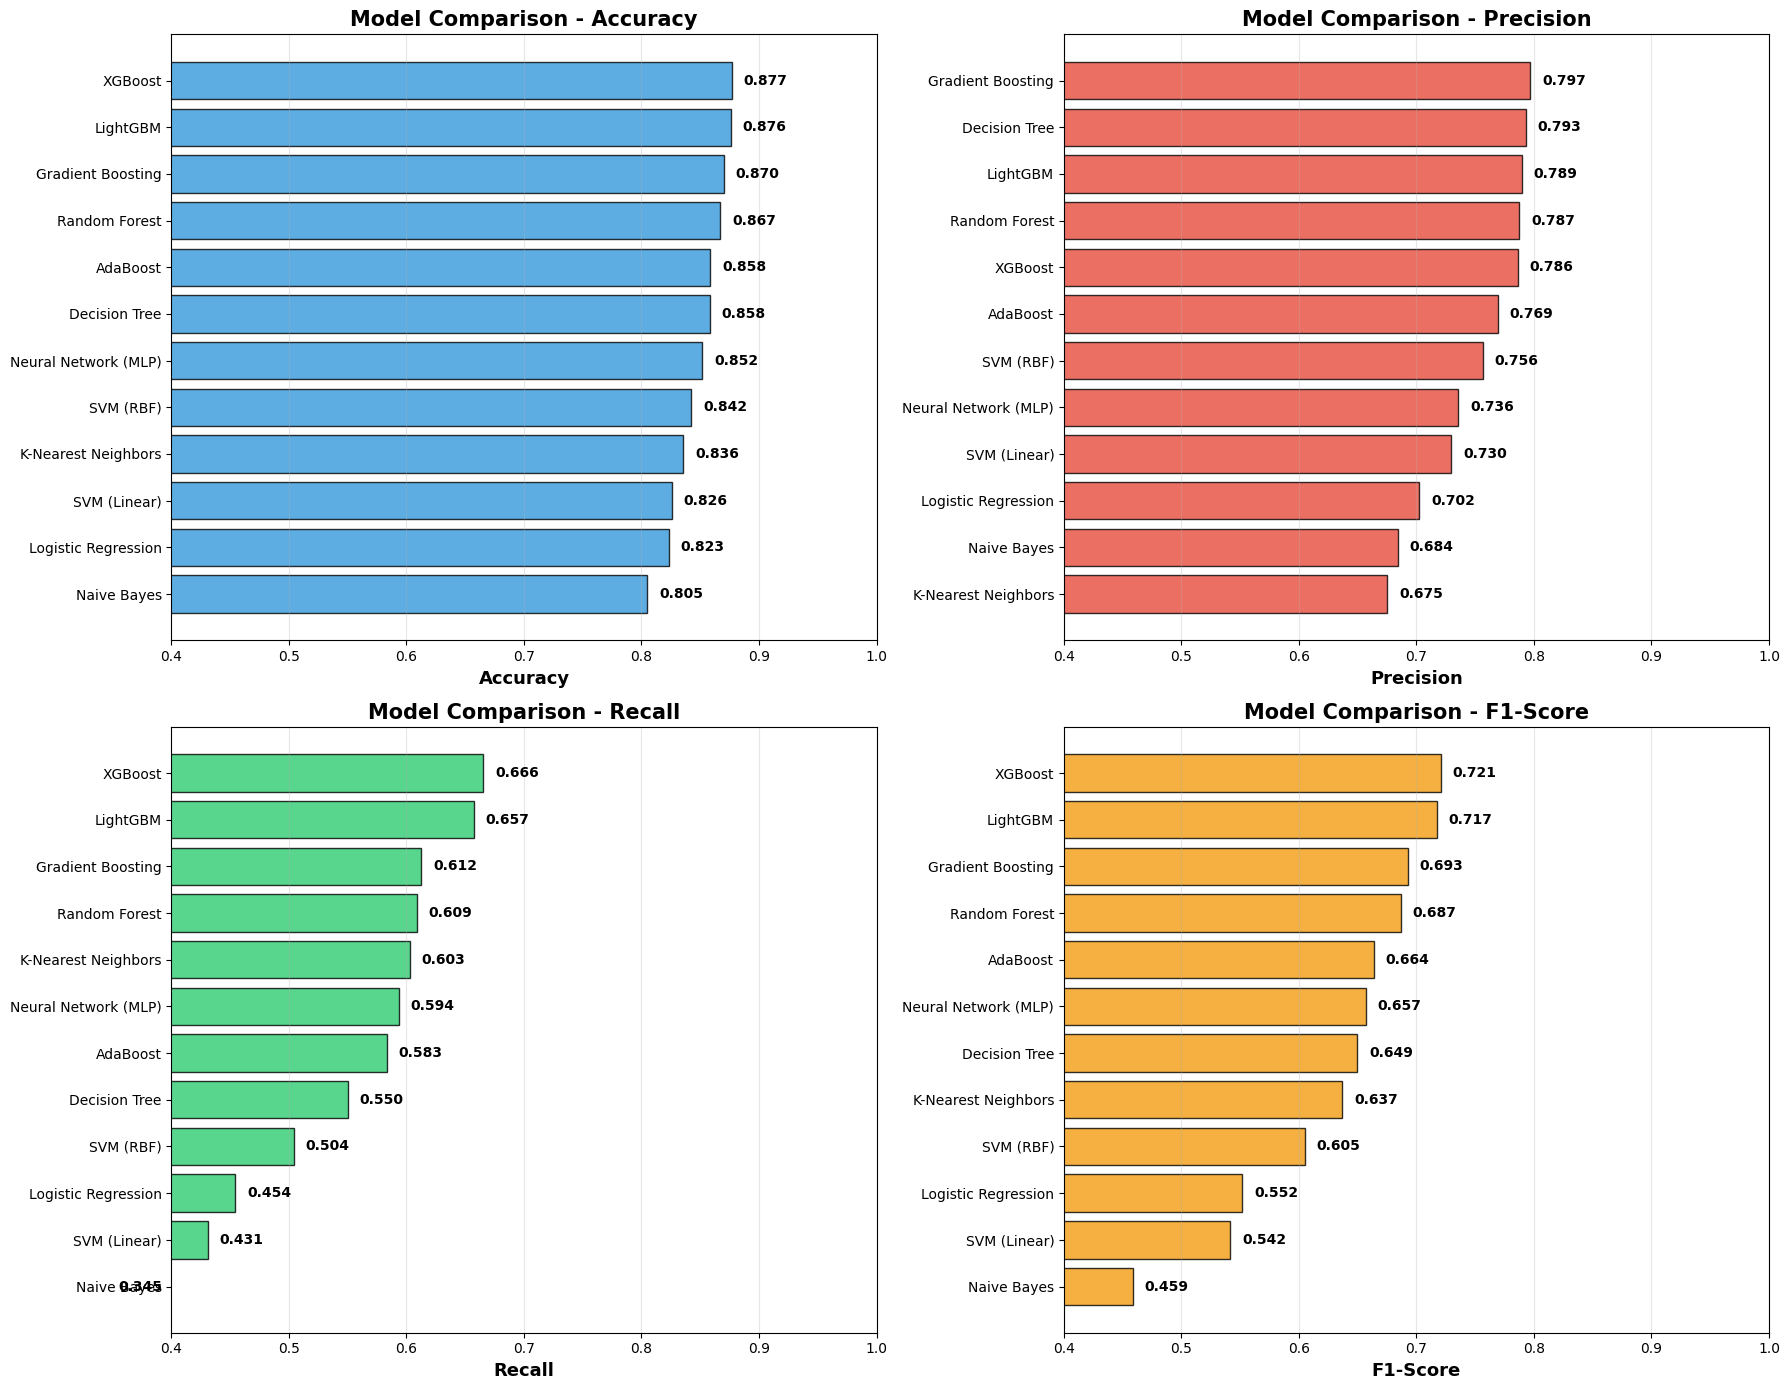

In [ ]:


fig, axes = plt.subplots(2, 2, figsize=(18, 14))
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
colors = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12']

for idx, metric in enumerate(metrics):
    ax = axes[idx // 2, idx % 2]
    data = comparison_df.sort_values(metric, ascending=True)

    bars = ax.barh(data['Model'], data[metric], color=colors[idx], alpha=0.8, edgecolor='black')
    ax.set_xlabel(metric, fontsize=13, fontweight='bold')
    ax.set_title(f'Model Comparison - {metric}', fontsize=15, fontweight='bold')
    ax.set_xlim([0.40, 1.0])
    ax.grid(axis='x', alpha=0.3)


    for i, (bar, v) in enumerate(zip(bars, data[metric])):
        ax.text(v + 0.01, i, f'{v:.3f}', va='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig('model_comparison_metrics.png', dpi=300, bbox_inches='tight')
plt.show()


COMPARISON OF THE TOP 5 MODELS

TOP 5 MODELS DETAILED COMPARISON
--------------------------------------------------------------------------------


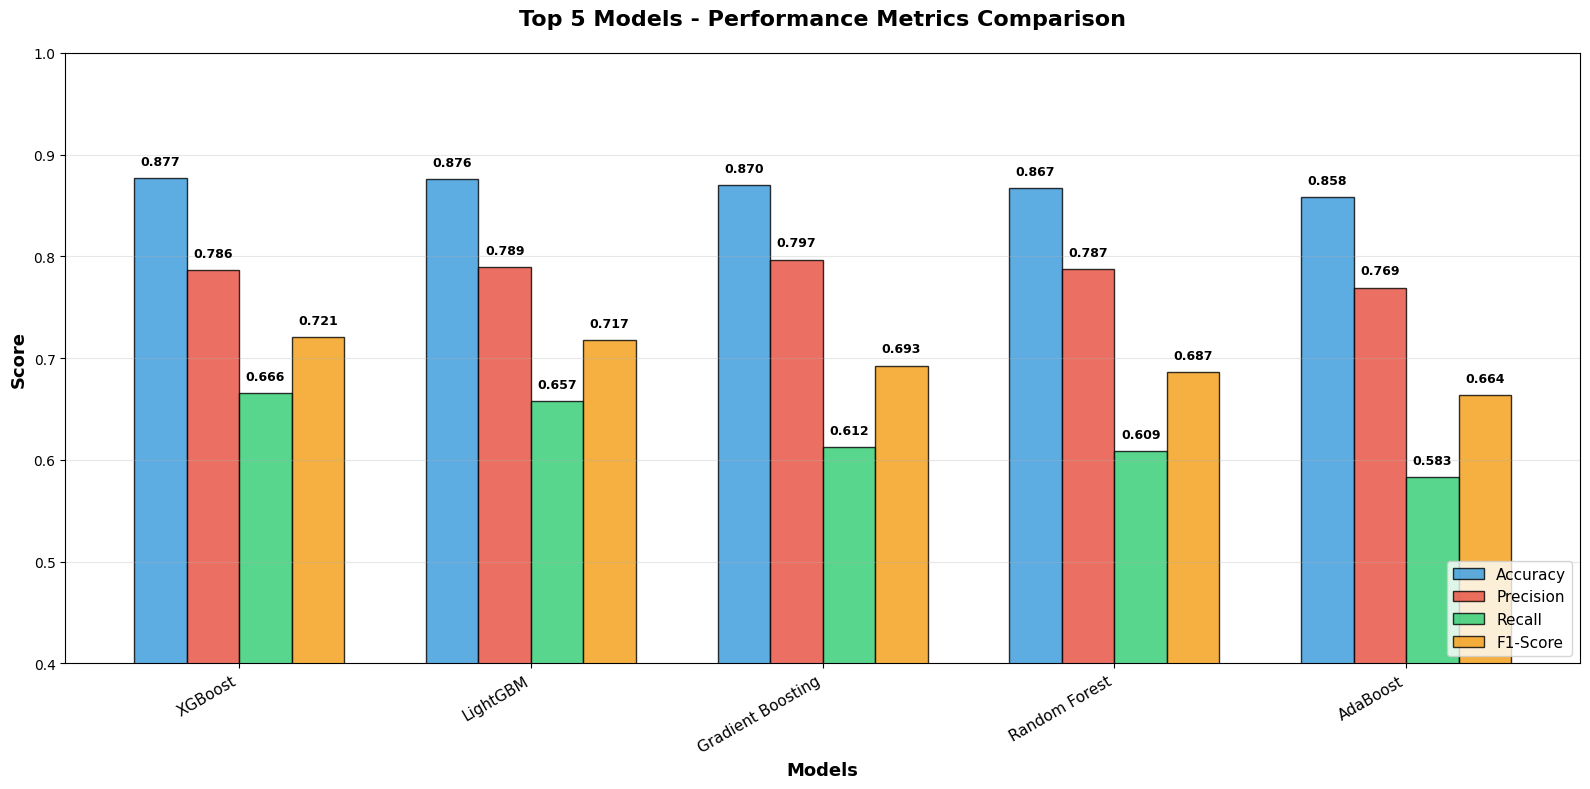

In [ ]:
print("TOP 5 MODELS DETAILED COMPARISON")
print("-"*80)

top_5 = comparison_df.head(5)

fig, ax = plt.subplots(figsize=(16, 8))

x = np.arange(len(top_5))
width = 0.18

metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
colors_bar = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12']

for i, metric in enumerate(metrics_to_plot):
    bars = ax.bar(x + i*width, top_5[metric], width, label=metric,
                  color=colors_bar[i], alpha=0.8, edgecolor='black')


    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.3f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

ax.set_xlabel('Models', fontsize=13, fontweight='bold')
ax.set_ylabel('Score', fontsize=13, fontweight='bold')
ax.set_title('Top 5 Models - Performance Metrics Comparison', fontsize=16, fontweight='bold', pad=20)
ax.set_xticks(x + width * 1.5)
ax.set_xticklabels(top_5['Model'], rotation=30, ha='right', fontsize=11)
ax.legend(fontsize=11, loc='lower right')
ax.grid(axis='y', alpha=0.3)
ax.set_ylim([0.40, 1.0])

plt.tight_layout()
plt.savefig('top5_models_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

ROC CURVES

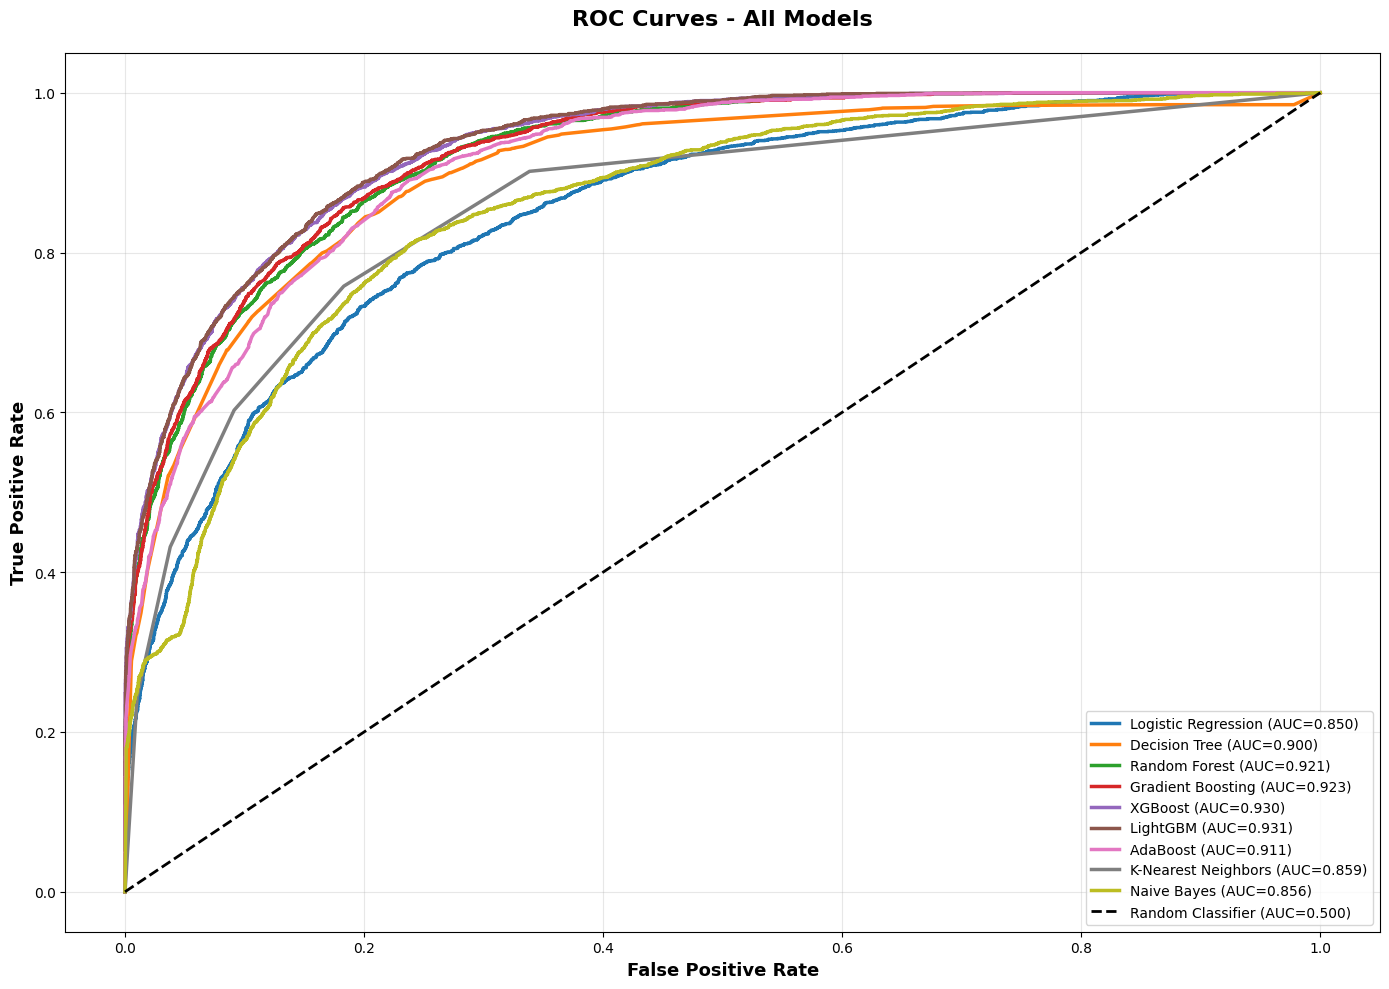


The closer the curve to the top left corner, the better the model
AUC (Area Under Curve) ranges from 0.5 (random) to 1.0 (perfect)


In [ ]:


plt.figure(figsize=(14, 10))

for name in results.keys():

    if 'y_pred_proba' in results[name] and results[name]['y_pred_proba'] is not None:
        y_score = results[name]['y_pred_proba']
        fpr, tpr, _ = roc_curve(y_test, y_score)
        auc = results[name]['roc_auc']
        plt.plot(fpr, tpr, label=f'{name} (AUC={auc:.3f})', linewidth=2.5)


plt.plot([0, 1], [0, 1], 'k--', linewidth=2, label='Random Classifier (AUC=0.500)')

plt.xlabel('False Positive Rate', fontsize=13, fontweight='bold')
plt.ylabel('True Positive Rate', fontsize=13, fontweight='bold')
plt.title('ROC Curves - All Models', fontsize=16, fontweight='bold', pad=20)
plt.legend(loc='lower right', fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('roc_curves_all_models.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nThe closer the curve to the top left corner, the better the model")
print("AUC (Area Under Curve) ranges from 0.5 (random) to 1.0 (perfect)")

CONFUSION MATRICES



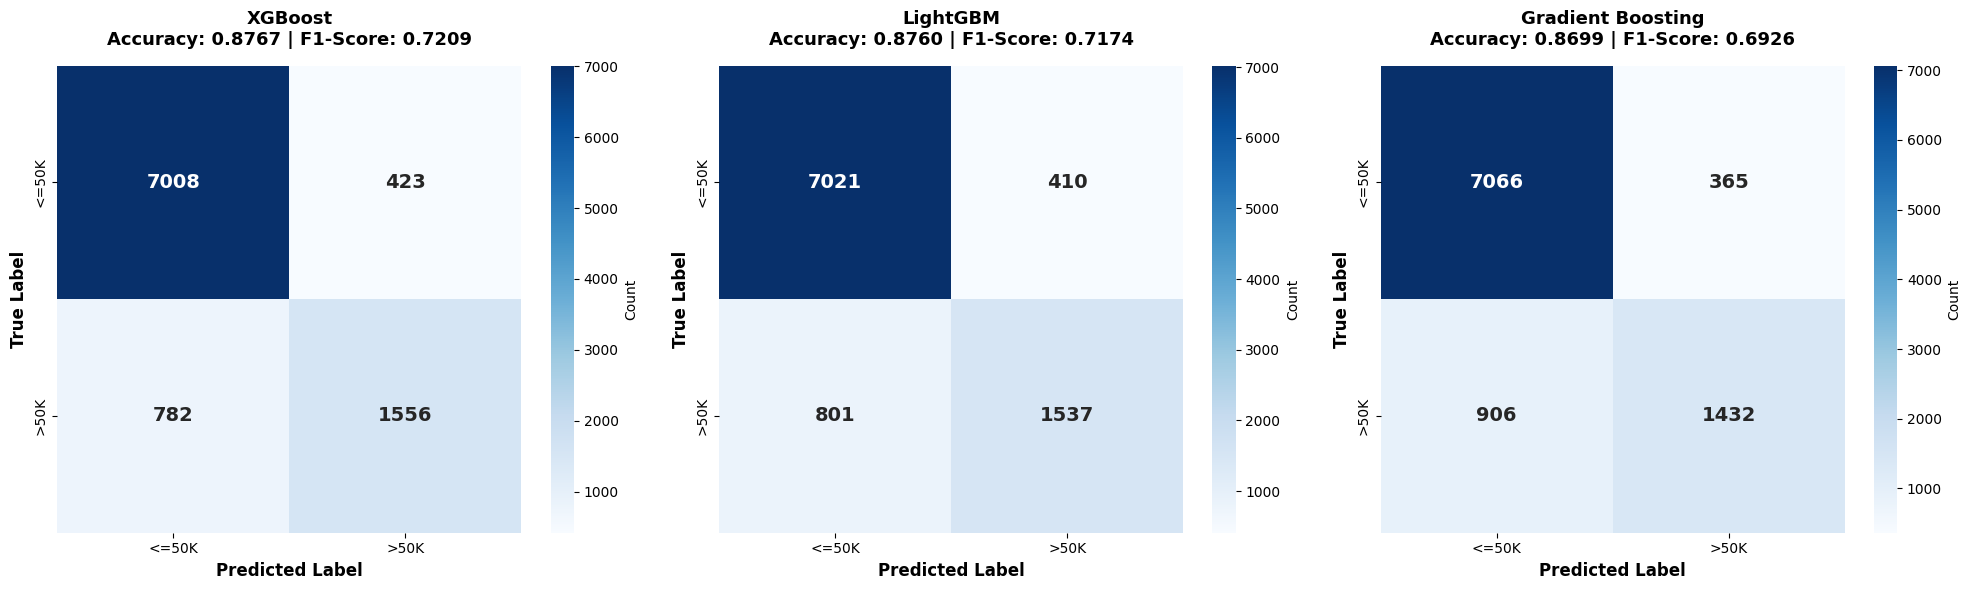


Confusion Matrix Explanation:
  Top left (TN : True Negative): Correctly predicted <=50K
  Top right (FP : False Positive): Incorrectly predicted >50K (actually <=50K)
  Bottom left (FN : False Negative): Incorrectly predicted <=50K (actually >50K)
  Bottom right (TP : True Positive): Correctly predicted >50K

Detailed Confusion Matrix Statistics:

XGBoost:
  True Negatives:  7,008 | False Positives: 423
  False Negatives: 782 | True Positives:  1,556
  Total Correct: 8,564 (87.67%)
  Total Wrong:   1,205 (12.33%)

LightGBM:
  True Negatives:  7,021 | False Positives: 410
  False Negatives: 801 | True Positives:  1,537
  Total Correct: 8,558 (87.60%)
  Total Wrong:   1,211 (12.40%)

Gradient Boosting:
  True Negatives:  7,066 | False Positives: 365
  False Negatives: 906 | True Positives:  1,432
  Total Correct: 8,498 (86.99%)
  Total Wrong:   1,271 (13.01%)


In [ ]:

top_3_models = comparison_df.head(3)['Model'].tolist()

fig, axes = plt.subplots(1, 3, figsize=(20, 6))

for idx, model_name in enumerate(top_3_models):
    cm = results[model_name]['confusion_matrix']


    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx],
                xticklabels=['<=50K', '>50K'], yticklabels=['<=50K', '>50K'],
                cbar_kws={'label': 'Count'}, annot_kws={'size': 14, 'weight': 'bold'})


    tn, fp, fn, tp = cm.ravel()

    axes[idx].set_title(f'{model_name}\nAccuracy: {results[model_name]["accuracy"]:.4f} | '
                       f'F1-Score: {results[model_name]["f1_score"]:.4f}',
                       fontsize=13, fontweight='bold', pad=15)
    axes[idx].set_ylabel('True Label', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Predicted Label', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('confusion_matrices_top3.png', dpi=300, bbox_inches='tight')
plt.show()


print("\nConfusion Matrix Explanation:")
print("  Top left (TN : True Negative): Correctly predicted <=50K")
print("  Top right (FP : False Positive): Incorrectly predicted >50K (actually <=50K)")
print("  Bottom left (FN : False Negative): Incorrectly predicted <=50K (actually >50K)")
print("  Bottom right (TP : True Positive): Correctly predicted >50K")


print("\nDetailed Confusion Matrix Statistics:")
for model_name in top_3_models:
    cm = results[model_name]['confusion_matrix']
    tn, fp, fn, tp = cm.ravel()
    print(f"\n{model_name}:")
    print(f"  True Negatives:  {tn:,} | False Positives: {fp:,}")
    print(f"  False Negatives: {fn:,} | True Positives:  {tp:,}")
    print(f"  Total Correct: {tn+tp:,} ({(tn+tp)/len(y_test)*100:.2f}%)")
    print(f"  Total Wrong:   {fp+fn:,} ({(fp+fn)/len(y_test)*100:.2f}%)")

FEATURE IMPORTANCE ANALYSIS

FEATURE IMPORTANCE ANALYSIS
--------------------------------------------------------------------------------
Models with feature importance: ['Decision Tree', 'Random Forest', 'Gradient Boosting', 'XGBoost', 'LightGBM', 'AdaBoost']
Number of features available: 13
Showing top 13 features (out of 13 total)

Top 5 Important Features for Decision Tree:
  1. relationship: 0.3863
  2. education-num: 0.2143
  3. capital-gain: 0.2082
  4. capital-loss: 0.0721
  5. age: 0.0458

Top 5 Important Features for Random Forest:
  1. capital-gain: 0.1846
  2. relationship: 0.1815
  3. education-num: 0.1396
  4. marital-status: 0.1096
  5. age: 0.1015

Top 5 Important Features for Gradient Boosting:
  1. relationship: 0.3482
  2. capital-gain: 0.2200
  3. education-num: 0.2123
  4. capital-loss: 0.0628
  5. age: 0.0584

Top 5 Important Features for XGBoost:
  1. relationship: 0.3170
  2. marital-status: 0.1795
  3. education-num: 0.1505
  4. capital-gain: 0.1355
  5. capital-loss: 0.0583


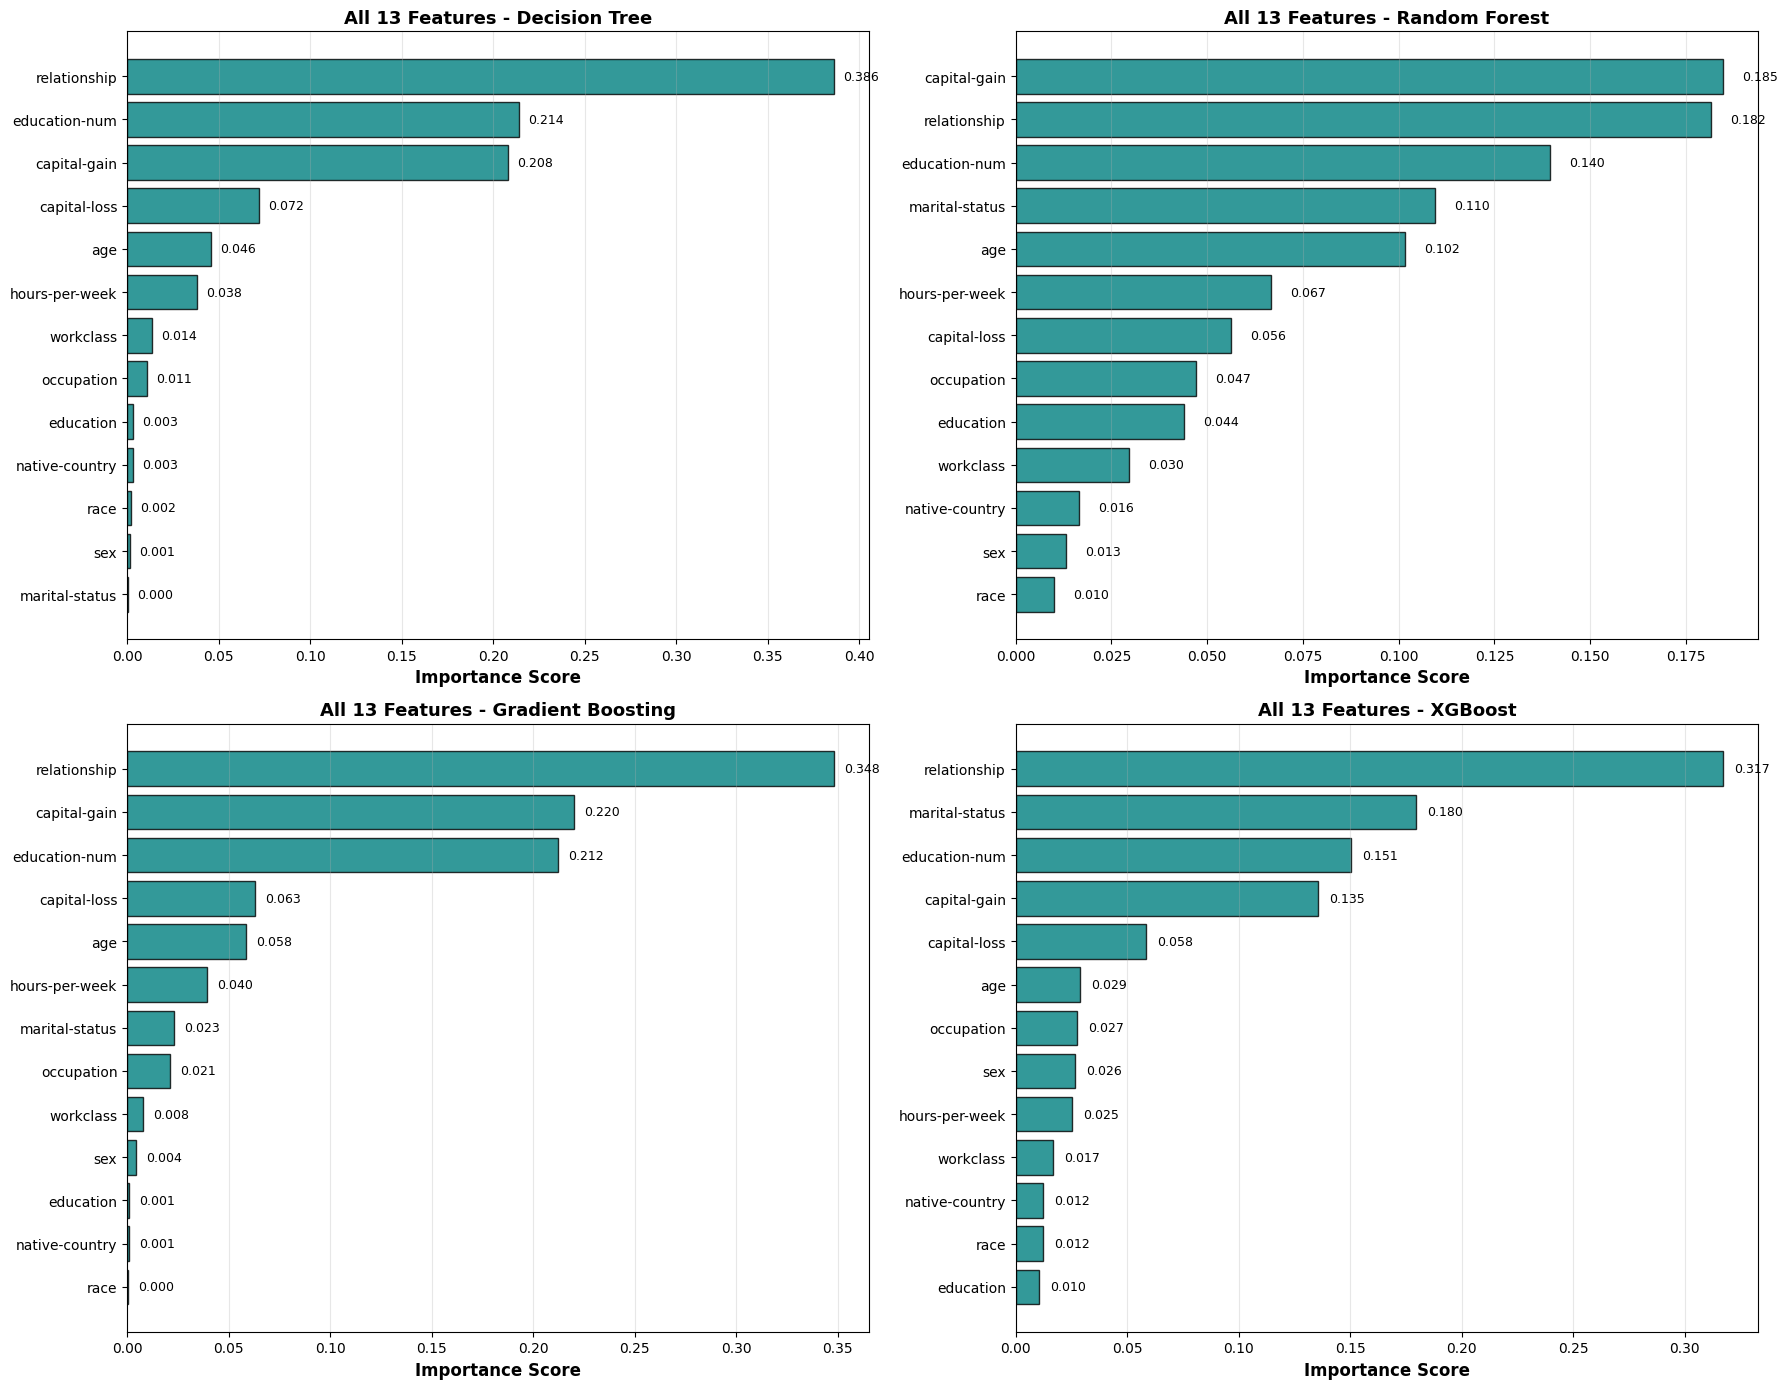


Most Consistently Important Features Across All Models:

Ranked by average importance across 6 models:
   1. age: 88.8863 (in top-5 of 5/6 models)
   2. capital-gain: 63.1793 (in top-5 of 6/6 models)
   3. capital-loss: 58.0558 (in top-5 of 5/6 models)
   4. hours-per-week: 56.3703 (in top-5 of 1/6 models)
   5. occupation: 54.5244 (in top-5 of 1/6 models)
   6. education-num: 44.8017 (in top-5 of 5/6 models)
   7. workclass: 27.3463 (in top-5 of 0/6 models)
   8. relationship: 27.0833 (in top-5 of 5/6 models)
   9. marital-status: 25.2209 (in top-5 of 2/6 models)
  10. native-country: 21.3388 (in top-5 of 0/6 models)

Feature Importance Statistics:
  Total features: 13
  Features displayed in charts: 13
  Models analyzed: 6


In [ ]:
print("FEATURE IMPORTANCE ANALYSIS")
print("-"*80)

feature_importance_models = []
for model_name in results.keys():
    if hasattr(results[model_name]['model'], 'feature_importances_'):
        feature_importance_models.append(model_name)

print(f"Models with feature importance: {feature_importance_models}")
print(f"Number of features available: {len(X.columns)}")

n_features = len(X.columns)
n_features_to_show = min(15, n_features)

print(f"Showing top {n_features_to_show} features (out of {n_features} total)")

n_models = len(feature_importance_models)
if n_models >= 4:
    fig, axes = plt.subplots(2, 2, figsize=(18, 14))
    axes = axes.ravel()
elif n_models == 3:
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))
elif n_models == 2:
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
else:
    fig, axes = plt.subplots(1, 1, figsize=(10, 8))
    axes = [axes]

feature_names = X.columns.tolist()

for idx, model_name in enumerate(feature_importance_models[:4]):
    model = results[model_name]['model']
    importances = model.feature_importances_


    feat_imp_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values('Importance', ascending=False).head(n_features_to_show)


    bars = axes[idx].barh(feat_imp_df['Feature'], feat_imp_df['Importance'],
                         color='teal', alpha=0.8, edgecolor='black')
    axes[idx].set_xlabel('Importance Score', fontsize=12, fontweight='bold')


    n_shown = len(feat_imp_df)
    if n_shown == n_features:
        title = f'All {n_features} Features - {model_name}'
    else:
        title = f'Top {n_shown} Important Features - {model_name}'

    axes[idx].set_title(title, fontsize=13, fontweight='bold')
    axes[idx].invert_yaxis()
    axes[idx].grid(axis='x', alpha=0.3)


    for i, (bar, v) in enumerate(zip(bars, feat_imp_df['Importance'])):
        axes[idx].text(v + 0.005, i, f'{v:.3f}', va='center', fontsize=9)


    print(f"\nTop 5 Important Features for {model_name}:")
    for rank, (_, row) in enumerate(feat_imp_df.head(5).iterrows(), 1):
        print(f"  {rank}. {row['Feature']}: {row['Importance']:.4f}")

plt.tight_layout()
plt.savefig('feature_importance_analysis.png', dpi=300, bbox_inches='tight')
plt.show()



print("\nMost Consistently Important Features Across All Models:")
all_features = {}
for model_name in feature_importance_models:
    model = results[model_name]['model']
    importances = model.feature_importances_
    for feat, imp in zip(feature_names, importances):
        if feat not in all_features:
            all_features[feat] = []
        all_features[feat].append(imp)

avg_importance = {feat: np.mean(imps) for feat, imps in all_features.items()}
sorted_features = sorted(avg_importance.items(), key=lambda x: x[1], reverse=True)

print(f"\nRanked by average importance across {len(feature_importance_models)} models:")
for rank, (feat, avg_imp) in enumerate(sorted_features[:10], 1):

    top5_count = sum(1 for model_name in feature_importance_models
                     if feat in pd.DataFrame({
                         'Feature': feature_names,
                         'Importance': results[model_name]['model'].feature_importances_
                     }).nlargest(5, 'Importance')['Feature'].values)

    print(f"  {rank:2d}. {feat}: {avg_imp:.4f} (in top-5 of {top5_count}/{len(feature_importance_models)} models)")


print(f"\nFeature Importance Statistics:")
print(f"  Total features: {n_features}")
print(f"  Features displayed in charts: {n_features_to_show}")
print(f"  Models analyzed: {len(feature_importance_models)}")


BEST MODEL DETAILED ANALYSIS

In [ ]:
print("BEST MODEL DETAILED ANALYSIS")
print("-"*80)

best_model_name = comparison_df.iloc[0]['Model']
best_model_results = results[best_model_name]

print(f"\nBest Performing Model: {best_model_name}")
print("-"*80)

print(f"\nPerformance Metrics:")
print(f"  Accuracy:  {best_model_results['accuracy']:.4f} ({best_model_results['accuracy']*100:.2f}%)")
print(f"  Precision: {best_model_results['precision']:.4f} (of predicted >50K, {best_model_results['precision']*100:.2f}% are correct)")
print(f"  Recall:    {best_model_results['recall']:.4f} (found {best_model_results['recall']*100:.2f}% of actual >50K)")
print(f"  F1 Score:  {best_model_results['f1_score']:.4f} (harmonic mean of precision & recall)")
print(f"  ROC AUC:   {best_model_results['roc_auc']:.4f} (discrimination ability)")
print(f"  CV Score:  {best_model_results['cv_mean']:.4f} (+/- {best_model_results['cv_std']:.4f})")

print(f"\nClassification Report:")
print("-"*80)
print(classification_report(y_test, best_model_results['y_pred'],
                           target_names=['<=50K', '>50K']))

print(f"\nConfusion Matrix:")
print("-"*80)
cm = best_model_results['confusion_matrix']
print(cm)

tn, fp, fn, tp = cm.ravel()
print(f"\nDetailed Breakdown:")
print(f"  True Negatives  (<=50K predicted correctly): {tn:,}")
print(f"  False Positives (<=50K predicted as >50K):   {fp:,}")
print(f"  False Negatives (>50K predicted as <=50K):   {fn:,}")
print(f"  True Positives  (>50K predicted correctly):  {tp:,}")

print(f"\nModel Interpretation:")
total = len(y_test)
correct = tn + tp
wrong = fp + fn
print(f"  Out of {total:,} test samples:")
print(f"   {correct:,} were correctly classified ({correct/total*100:.2f}%)")
print(f"   {wrong:,} were misclassified ({wrong/total*100:.2f}%)")

print(f"\nError Analysis:")
print(f"  Type I Error (False Positive Rate):  {fp/(fp+tn)*100:.2f}%")
print(f"  Type II Error (False Negative Rate): {fn/(fn+tp)*100:.2f}%")

BEST MODEL DETAILED ANALYSIS
--------------------------------------------------------------------------------

Best Performing Model: XGBoost
--------------------------------------------------------------------------------

Performance Metrics:
  Accuracy:  0.8767 (87.67%)
  Precision: 0.7863 (of predicted >50K, 78.63% are correct)
  Recall:    0.6655 (found 66.55% of actual >50K)
  F1 Score:  0.7209 (harmonic mean of precision & recall)
  ROC AUC:   0.9303 (discrimination ability)
  CV Score:  0.8715 (+/- 0.0025)

Classification Report:
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

       <=50K       0.90      0.94      0.92      7431
        >50K       0.79      0.67      0.72      2338

    accuracy                           0.88      9769
   macro avg       0.84      0.80      0.82      9769
weighted avg       0.87      0.88      0.87      9769


Confusion Matrix:
-----------------------------

HYPERPARAMETER TUNING


In [ ]:
print("HYPERPARAMETER TUNING - BEST MODEL")
print("-"*80)

best_model_name = comparison_df.iloc[0]['Model']
print(f"\nTuning hyperparameters for: {best_model_name}")

if best_model_name == 'Random Forest':
    print("\nRandom Forest Hyperparameter Tuning:")
    print("  Testing combinations of: n_estimators, max_depth, min_samples_split")


    baseline_acc = results['Random Forest']['accuracy']
    print(f"\n  Baseline Accuracy: {baseline_acc:.4f}")


    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [10, 15, 20, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }


    rf_model = RandomForestClassifier(random_state=42)


    print("\n  Running Grid Search...")
    grid_search = GridSearchCV(
        rf_model,
        param_grid,
        cv=3,
        scoring='accuracy',
        n_jobs=-1,
        verbose=1
    )

    grid_search.fit(X_train, y_train)


    print(f"\n Grid Search Complete!")
    print(f"\n Best Parameters Found:")
    for param, value in grid_search.best_params_.items():
        print(f"    {param}: {value}")

    print(f"\n  Best Cross-Validation Score: {grid_search.best_score_:.4f}")


    tuned_model = grid_search.best_estimator_
    y_pred_tuned = tuned_model.predict(X_test)
    tuned_acc = accuracy_score(y_test, y_pred_tuned)
    tuned_f1 = f1_score(y_test, y_pred_tuned)

    print(f"\nPERFORMANCE COMPARISON:")
    print(f"    Baseline Accuracy:  {baseline_acc:.4f}")
    print(f"    Tuned Accuracy:     {tuned_acc:.4f}")
    print(f"    Improvement:        {tuned_acc - baseline_acc:+.4f} ({(tuned_acc - baseline_acc)/baseline_acc*100:+.2f}%)")

    print(f"\nBaseline F1-Score:  {results['Random Forest']['f1_score']:.4f}")
    print(f"    Tuned F1-Score:     {tuned_f1:.4f}")
    print(f"    Improvement:        {tuned_f1 - results['Random Forest']['f1_score']:+.4f}")

elif best_model_name == 'XGBoost':
    print("\nXGBoost Hyperparameter Tuning:")

    baseline_acc = results['XGBoost']['accuracy']
    print(f"\n  Baseline Accuracy: {baseline_acc:.4f}")

    param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1, 0.3],
        'subsample': [0.8, 1.0]
    }

    xgb_model = XGBClassifier(random_state=42, eval_metric='logloss')

    print("\n  Running Grid Search...")
    grid_search = GridSearchCV(
        xgb_model,
        param_grid,
        cv=3,
        scoring='accuracy',
        n_jobs=-1,
        verbose=1
    )

    grid_search.fit(X_train, y_train)

    print(f"\n  Best Parameters Found:")
    for param, value in grid_search.best_params_.items():
        print(f"    {param}: {value}")

    tuned_model = grid_search.best_estimator_
    y_pred_tuned = tuned_model.predict(X_test)
    tuned_acc = accuracy_score(y_test, y_pred_tuned)
    tuned_f1 = f1_score(y_test, y_pred_tuned)

    print(f"\npERFORMANCE COMPARISON:")
    print(f"    Baseline Accuracy:  {baseline_acc:.4f}")
    print(f"    Tuned Accuracy:     {tuned_acc:.4f}")
    print(f"    Improvement:        {tuned_acc - baseline_acc:+.4f} ({(tuned_acc - baseline_acc)/baseline_acc*100:+.2f}%)")

else:
    print(f"\nHyperparameter tuning not configured for {best_model_name}")

HYPERPARAMETER TUNING - BEST MODEL
--------------------------------------------------------------------------------

Tuning hyperparameters for: XGBoost

XGBoost Hyperparameter Tuning:

  Baseline Accuracy: 0.8767

  Running Grid Search...
Fitting 3 folds for each of 36 candidates, totalling 108 fits

  Best Parameters Found:
    learning_rate: 0.1
    max_depth: 5
    n_estimators: 200
    subsample: 1.0

pERFORMANCE COMPARISON:
    Baseline Accuracy:  0.8767
    Tuned Accuracy:     0.8768
    Improvement:        +0.0001 (+0.01%)


In [ ]:
print("PROJECT SUMMARY")

total_samples = len(df)
n_features = len(X.columns)
n_train = len(X_train)
n_test = len(X_test)
n_low_income = (y == 0).sum()
n_high_income = (y == 1).sum()

summary = f"""
{'-'*80}
ADULT INCOME PREDICTION : PROJECT SUMMARY
{'-'*80}

DATASET INFORMATION
{'-'*80}
Total Samples:           {total_samples:,}
Number of Features:      {n_features}
Target Classes:          2 (<=50K, >50K)
Class Distribution:
   <=50K: {n_low_income:,} ({n_low_income/total_samples*100:.1f}%)
   >50K:  {n_high_income:,} ({n_high_income/total_samples*100:.1f}%)

Training Samples:        {n_train:,} ({n_train/total_samples*100:.1f}%)
Test Samples:            {n_test:,} ({n_test/total_samples*100:.1f}%)

MACHINE LEARNING MODELS TRAINED
{'-'*80}
Total Models:            {len(results)}

"""

for i, model_name in enumerate(results.keys(), 1):
    summary += f"{i:2d}. {model_name}\n"

summary += f"""
TOP 5 PERFORMING MODELS
{'-'*80}
"""

for i in range(min(5, len(comparison_df))):
    model_name = comparison_df.iloc[i]['Model']
    accuracy = comparison_df.iloc[i]['Accuracy']
    precision = comparison_df.iloc[i]['Precision']
    recall = comparison_df.iloc[i]['Recall']
    f1 = comparison_df.iloc[i]['F1-Score']
    auc = comparison_df.iloc[i]['ROC-AUC']

    summary += f"\n{i+1}. {model_name}\n"
    summary += f"   Accuracy:  {accuracy:.4f} | Precision: {precision:.4f}\n"
    summary += f"   Recall:    {recall:.4f} | F1-Score:  {f1:.4f} | ROC-AUC: {auc:.4f}\n"

summary += f"""
BEST MODEL DETAILS
{'-'*80}
Model:                   {best_model_name}
Accuracy:                {best_model_results['accuracy']:.4f} ({best_model_results['accuracy']*100:.2f}%)
Precision:               {best_model_results['precision']:.4f}
Recall:                  {best_model_results['recall']:.4f}
F1 Score:                {best_model_results['f1_score']:.4f}
ROC AUC:                 {best_model_results['roc_auc']:.4f}
Cross Validation Score:  {best_model_results['cv_mean']:.4f} (+/- {best_model_results['cv_std']:.4f})

Confusion Matrix:
  True Negatives:  {cm[0,0]:,}  |  False Positives: {cm[0,1]:,}
  False Negatives: {cm[1,0]:,}  |  True Positives:  {cm[1,1]:,}

KEY INSIGHTS
{'-'*80}
Model Performance:
 - Ensemble methods (Random Forest, XGBoost, LightGBM, Gradient Boosting)
   consistently outperform simpler models
 - Neural Network (MLP) shows strong performance with proper tuning
 - Best accuracy achieved: {comparison_df.iloc[0]['Accuracy']:.4f} ({comparison_df.iloc[0]['Accuracy']*100:.2f}%)
"""

print(summary)

with open('project_summary.txt', 'w') as f:
    f.write(summary)

PROJECT SUMMARY

--------------------------------------------------------------------------------
ADULT INCOME PREDICTION : PROJECT SUMMARY
--------------------------------------------------------------------------------

DATASET INFORMATION
--------------------------------------------------------------------------------
Total Samples:           48,842
Number of Features:      13
Target Classes:          2 (<=50K, >50K)
Class Distribution:
   <=50K: 37,155 (76.1%)
   >50K:  11,687 (23.9%)

Training Samples:        39,073 (80.0%)
Test Samples:            9,769 (20.0%)

MACHINE LEARNING MODELS TRAINED
--------------------------------------------------------------------------------
Total Models:            12

 1. Logistic Regression
 2. Decision Tree
 3. Random Forest
 4. Gradient Boosting
 5. XGBoost
 6. LightGBM
 7. AdaBoost
 8. SVM (Linear)
 9. SVM (RBF)
10. K-Nearest Neighbors
11. Naive Bayes
12. Neural Network (MLP)

TOP 5 PERFORMING MODELS
------------------------------------------

FINAL STATISTICS

In [ ]:

print("\nFINAL STATISTICS:")
print(f"  Total models trained: {len(results)}")
print(f"  Best model: {best_model_name}")
print(f"  Best accuracy: {best_model_results['accuracy']:.4f} ({best_model_results['accuracy']*100:.2f}%)")
print(f"  Files generated: {12 + 2} (12 images + 2 data files)")


FINAL STATISTICS:
  Total models trained: 12
  Best model: XGBoost
  Best accuracy: 0.8767 (87.67%)
  Files generated: 14 (12 images + 2 data files)
